# Práctica: Segmentación de clientes mayoristas (Wholesale customers – UCI)

## Contexto

El dataset **Wholesale customers** recoge información de clientes de un distribuidor mayorista.  
Cada fila es un cliente y las variables son:

- `Fresh`: gasto anual en productos frescos
- `Milk`: gasto anual en leche
- `Grocery`: gasto anual en alimentación general
- `Frozen`: gasto anual en congelados
- `Detergents_Paper`: gasto anual en detergentes y papel
- `Delicassen`: gasto anual en productos delicatessen
- `Channel`: canal del cliente (1 = Horeca: hoteles/restaurantes/cafés, 2 = Retail)
- `Region`: región (1 = Lisboa, 2 = Oporto, 3 = otras)

Objetivo: realizar una **segmentación de clientes** basada en los patrones de gasto y relacionarla con el canal y la región.

Aplicaremos:

1. **PCA** sobre los gastos para entender la estructura de la variabilidad.
2. **Clustering (k-means)** para obtener segmentos de clientes.
3. **Análisis de Correspondencias (CA)** para estudiar la relación entre segmentos y variables categóricas (`Channel`, `Region`).

---

## Instrucciones generales

- Completa las celdas que contienen comentarios `# TODO`.
- No elimines las celdas ni las preguntas en texto.
- Puedes añadir celdas adicionales para análisis extra.
- Entrega el notebook ejecutado, con todas las salidas visibles.


## 0. Importación de librerías

In [1]:
# ============================================================
# 0. Importación de librerías
# ============================================================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    adjusted_rand_score
)
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report

from matplotlib.lines import Line2D

sns.set(style="whitegrid", context="notebook")



print("Librerías importadas correctamente.")


Librerías importadas correctamente.


## 1. Carga del dataset y exploración inicial

El dataset original está disponible en el repositorio UCI como archivo CSV:

- Nombre: `Wholesale customers data.csv`

Si tienes conexión a internet en el entorno de Jupyter, puedes leerlo directamente desde la URL.  
Si no, deberás descargar el archivo previamente y leerlo desde disco.

En esta sección debes:

1. Cargar el dataset en un `DataFrame` de pandas.
2. Ver sus primeras filas.
3. Revisar tamaño, tipos de variables y valores faltantes.
4. Ver estadísticas descriptivas de las variables numéricas.
5. Explorar la distribución de `Channel` y `Region`.


In [2]:
# ============================================================
# 1. Carga del dataset
# ============================================================

# TODO 1.1: Define la URL o ruta local del archivo CSV
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"

# TODO 1.2: Carga el CSV en un DataFrame llamado 'data' usando pd.read_csv(...)
data = pd.read_csv(url)

# TODO 1.3: Muestra las primeras filas

print("Dataset cargado correctamente \n")
print("\nPrimeras 5 filas:")
data.head()


Dataset cargado correctamente 


Primeras 5 filas:


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
# TODO 1.4: Muestra dimensiones, información general y resumen estadístico de las variables numéricas

print("Dimensiones del dataset:", data.shape)
print(f"Número de filas (clientes): {data.shape[0]}")
print(f"Número de columnas (variables): {data.shape[1]}")


print("\nInformación general:")
data.info()

print("\nResumen estadístico: \n")
variables_gasto = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

display(data[variables_gasto].describe())


Dimensiones del dataset: (440, 8)
Número de filas (clientes): 440
Número de columnas (variables): 8

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB

Resumen estadístico: 



,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### **Análisis de Estructura e Integridad**

El conjunto de datos presenta una estructura inicial de 440 registros y 8 columnas, todas codificadas como enteros `(int64)`. Se trata de un dataset de dimensión pequeña al solo contener 440 observaciones. Afortunadamente, el dataset cuenta con una integridad del 100%, ya que no existen valores faltantes *(missings)* en ninguna de las variables; esto nos entrega una base de datos limpia que permite utilizar la muestra completa sin incurrir en sesgos derivados de técnicas de imputación.

Ademas, como primera observación cabe destacar la disparidad de escalas que muestran las variables. Por ejemplo, en la variable `Fresh` el mínimo se encuentra en 3, y el máximo en 112.151 mientras que en la variable `Frozen` tenemos min = 25 max = 60.869. Este hecho hará imprescindible la **estandarización** posterior para evitar que las variables con mayor magnitud dominen de forma desproporcionada el análisis de PCA o K-means.

Heterogeneidad de la muestra: La desviación típica es mayor media. El distribuidor parece que atiende desde negocios minúsculos (gasto anual de 3 unidades) hasta gigantes del sector, lo que subraya la diversidad del comportamiento de compra.

### **Detección Preliminar de Outliers**

Al contrastar la media con los cuartiles, se evidencian indicios claros de valores atípicos y distribuciones con un marcado **sesgo positivo** en todas las categorías de gasto anual:

* **Diferencia Media vs. Mediana:** En variables como `Fresh`, mientras que el 50% de los clientes gasta hasta **8.504** unidades, la media asciende a **~ 12.000** debido a la influencia de valores extremadamente altos.
* **Salto Cuartil 3 (75%) vs. Máximo:**
  * En `Detergents_Paper`, el 75% de los clientes presenta un gasto inferior a **3.922** unidades, mientras que el valor máximo alcanza las **40.827**, situándose a una distancia muy significativa tanto del tercer cuartil como de la media.
  * En `Delicassen`, el sesgo positivo se evidencia en el  valor máximo (**47.943**) muy alejado del tercer cuartil (**1820.25**), indicando la existencia de **"Súper Clientes"** con consumos excepcionalmente elevados en relación con el gasto típico.

Todo indica que existen clientes singulares con volúmnes de compra excepcionalmete alto formando el conjunto de valores atípicos.  Para contrastar nuestras esta hipótesis, decidimos realizar un estudio con diagramas de cajas para confirmarlo de forma visual.



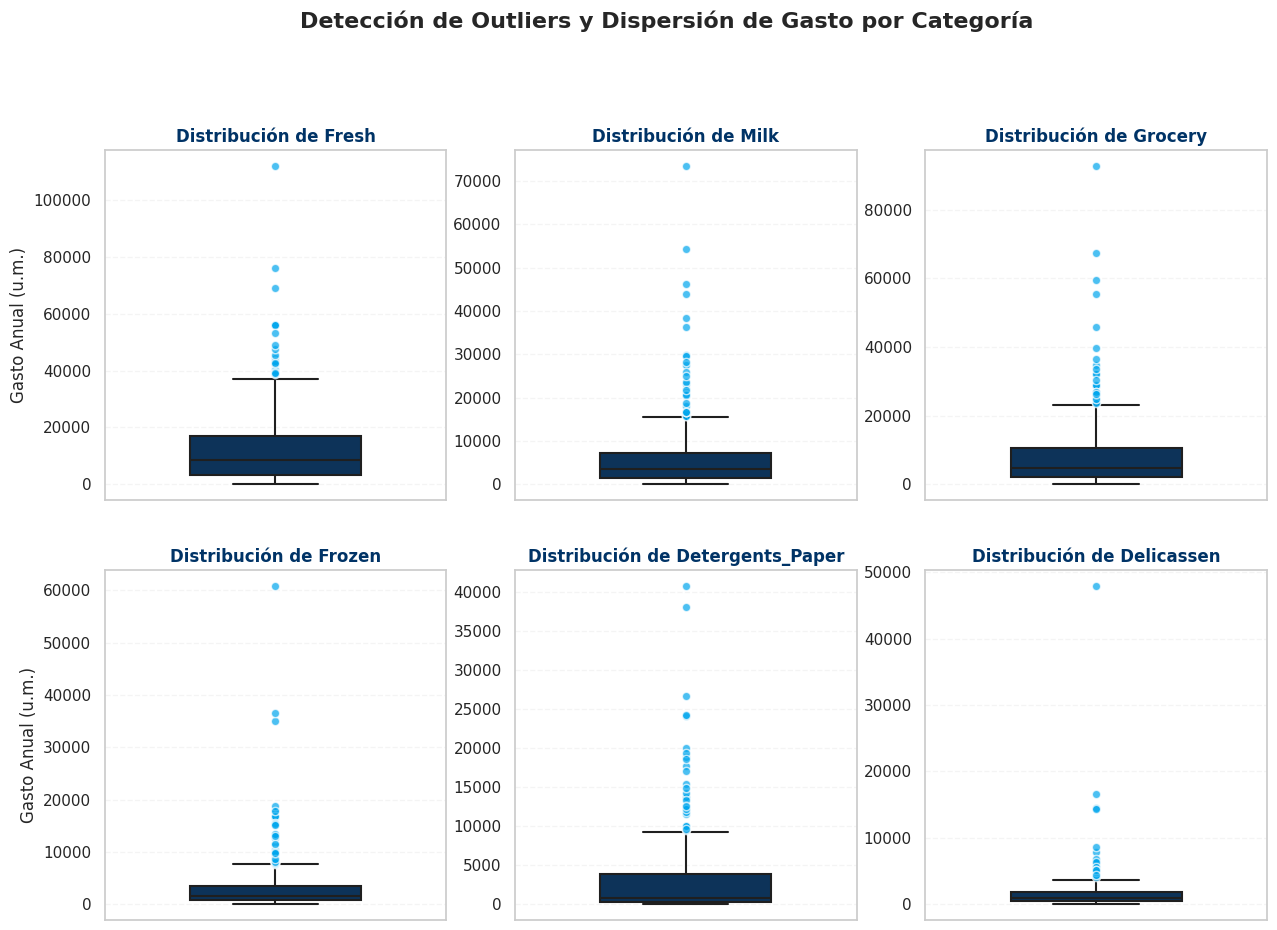

In [4]:
# Análisis de outliers mediante boxplots

color_principal = '#003366'
color_outliers = '#00A6ED'

plt.figure(figsize=(15, 10))
for i, var in enumerate(variables_gasto, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=data[var],
                color=color_principal,
                width=0.5,
                linewidth=1.5,
                flierprops={'markerfacecolor': color_outliers,
                            'markeredgecolor': 'white',
                            'marker': 'o',
                            'markersize': 6,
                            'alpha': 0.7})

    plt.title(f'Distribución de {var}', fontsize=12, fontweight='bold', color=color_principal)
    plt.ylabel('Gasto Anual (u.m.)' if i in [1, 4] else "")
    plt.grid(axis='y', alpha=0.2, linestyle='--')

plt.suptitle('Detección de Outliers y Dispersión de Gasto por Categoría',
             fontsize=16, fontweight='bold', y=1.02)
plt.show()


### **Análisis Visual de la Distribución**

El análisis mediante **boxplots** confirma la estructura detectada numéricamente:

* **Asimetría Positiva:** En todas las categorías, el 50% central de los datos (la caja) está situada en la zona de gastos bajos/medios, mientras que los valores atípicos se extienden largamente hacia la parte superior. Por ejemplo, en `Milk`, la media es de 5.796 mientras el **50**% de los clientes gasta menos de 3.627, indicando que unos pocos clientes con gastos masivos desplazan el promedio hacia arriba.
* **Presencia de "Súper Clientes":** Los outliers identificados (puntos azul clarito) no se consideran errores de medición, sino que representan clientes reales con un peso estratégico significativo, como grandes superficies, hoteles de gran capacidad o centros logísticos.
* **Decisión Técnica:** **Se conservan todos los registros**. Su exclusión supondría una pérdida de información crítica; el objetivo del clustering será precisamente identificar si estos clientes de gran volumen forman un segmento propio y diferenciado del resto de la cartera.


Distribución de Channel:


,count
Channel,
Horeca,298
Retail,142



Distribución de Region:


,count
Region,
Otras,316
Lisboa,77
Oporto,47


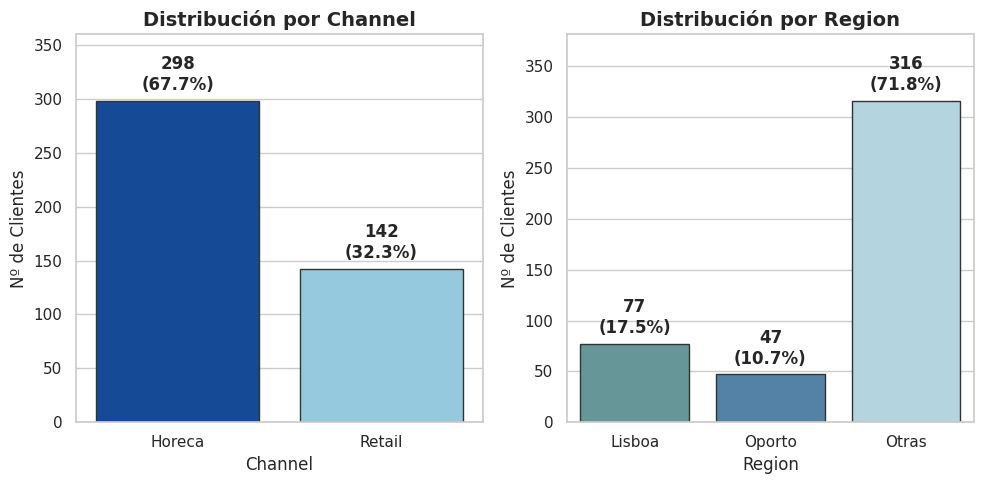


--- Relación Canal vs Región (Frecuencia Absoluta) ---


Region,Lisboa,Oporto,Otras,All
Channel,,,,
Horeca,59,28,211,298
Retail,18,19,105,142
All,77,47,316,440



--- Relación Canal vs Región (% por Fila/Canal) ---


Region,Lisboa,Oporto,Otras
Channel,,,
Horeca,19.8%,9.4%,70.8%
Retail,12.7%,13.4%,73.9%
All,17.5%,10.7%,71.8%


In [5]:
# TODO 1.5: Explora la distribución de 'Channel' y 'Region'
channel_labels = {1: "Horeca", 2: "Retail"}
region_labels = {1: "Lisboa", 2: "Oporto", 3: "Otras"}

# 1. Tablas de Frecuencia
for col, labels in zip(['Channel', 'Region'], [channel_labels, region_labels]):
    print(f"\nDistribución de {col}:")
    display(data[col].map(labels).value_counts())

# 2. Visualización
plt.figure(figsize=(10, 5))
vars_plot = [('Channel', channel_labels, ['#0047AB', '#87CEEB']),
             ('Region', region_labels, ['#5F9EA0', '#4682B4', '#ADD8E6'])]

for i, (col, labels, paleta) in enumerate(vars_plot, 1):
    plt.subplot(1, 2, i)
    ax = sns.countplot(x=col, data=data, hue=col, palette=paleta, edgecolor='0.2', legend=False)

    plt.title(f'Distribución por {col}', fontweight='bold', fontsize=14)
    plt.xticks(range(len(labels)), labels.values())
    plt.xlabel(col)
    plt.ylabel('Nº de Clientes')

    # Etiquetas de valor y porcentaje automáticas
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f'{int(h)}\n({100*h/len(data):.1f}%)',
                    (p.get_x() + p.get_width()/2., h),
                    ha='center', va='bottom', xytext=(0, 5),
                    textcoords='offset points', fontweight='bold')
    ax.set_ylim(0, ax.get_ylim()[1] * 1.15)

plt.tight_layout()
plt.show()

# 3. Análisis de Relación (Tablas Cruzadas)
print("\n--- Relación Canal vs Región (Frecuencia Absoluta) ---")
ct = pd.crosstab(data['Channel'].map(channel_labels),
                 data['Region'].map(region_labels), margins=True)
display(ct)

print("\n--- Relación Canal vs Región (% por Fila/Canal) ---")
ct_pct = pd.crosstab(data['Channel'].map(channel_labels),
                     data['Region'].map(region_labels),
                     normalize='index', margins=True) * 100
display(ct_pct.round(1).astype(str) + '%')


### Preguntas de interpretación inicial

1. ¿Cuántos clientes y cuántas variables contiene el dataset?
2. ¿Existen valores faltantes en alguna variable?
3. ¿Cómo se reparten aproximadamente los clientes entre los canales (Horeca vs Retail)?
4. ¿Y entre las regiones?

*(Responde aquí con uno o varios párrafos.)*





#### **1. ¿Cuántos clientes y cuántas variables contiene el dataset?**
El conjunto de datos está compuesto por **440 observaciones (clientes) y 8 variables**. Es un dataset con todas las variables codificadas como enteros (`int64`). Desde el punto de vista analítico, distinguimos dos naturalezas de datos:

* **Variables Categóricas (Descriptivas):** Describen las características del cliente mediante `Channel` para el tipo de negocio (1: Horeca / 2: Retail) y `Region` para la ubicación geográfica (1: Lisboa, 2: Oporto, 3: Otras).
* **Variables Numéricas (Métricas de gasto):** Representan los gastos anuales en seis categorías de productos (`Fresh`, `Milk`, `Grocery`, `Frozen`, `Detergents_Paper` y `Delicassen`).

#### **2. ¿Existen valores faltantes en alguna variable?**
El dataset presenta una **integridad del 100%**, sin valores faltantes (`Non-Null Count: 440` en todas las columnas). El hecho de contar con datos completos facilita los análisis posteriores, ya que elimina la necesidad de técnicas de imputación que podrían introducir sesgos.

#### **3. ¿Cómo se reparten aproximadamente los clientes entre los canales (Horeca vs Retail)?**

Existe un dominio claro del canal **Horeca** (Hoteles, Restaurantes y Cafeterías), que representa a **298 clientes (67.7%)**, duplicando holgadamente al canal **Retail** (Supermercados y minoristas), que cuenta con **142 clientes (32.3%)**.

* **Perfil del Negocio:** Esta distribución sitúa al distribuidor principalmente como un proveedor clave para el sector de servicios alimentarios. La proporción de aproximadamente **2:1** indica que la mayor parte de la operativa logística y comercial está orientada a satisfacer las necesidades de consumo inmediato y hostelería.


#### **4. ¿Y entre las regiones?**

La distribución geográfica muestra una fuerte concentración en la categoría **"Otras Regiones" (Región 3)**, con **316 clientes (71.8%)**, seguida por **Lisboa (17.5%)** y **Oporto (10.7%)**. Sin embargo, este análisis requiere una lectura detallada basada en el cruce de variables:

* **Interpretación de la Región 3:** La elevada frecuencia en "Otras Regiones" debe interpretarse con cautela. Es probable que esta categoría actúe englobando múltiples áreas geográficas del país, mientras que Lisboa y Oporto representan núcleos urbanos específicos. Por tanto, la representatividad de la Región 3 (71.8%) responde más a una agregación territorial que a una dominancia de un punto geográfico concreto.

* **Equilibrio y Coherencia Regional:** Al analizar la relación entre `Channel` y `Region`, se observa un patrón geográfico muy consistente: tanto en **Horeca (70.8%)** como en **Retail (74.0%)**, la gran mayoría de los clientes se concentran en la Región 3. Esto indica que el tipo de negocio no influye en dónde están situados los clientes; la distribución es muy parecida en todas las regiones.

* **Núcleo del Negocio y Diferenciación en la Capital:**
  * **El motor del negocio:** El segmento principal de la empresa es la combinación **Horeca / Otras Regiones**. Con 211 clientes, representa el **48.0%** (casi la mitad) de la muestra total, consolidándose como el nicho de mercado más crítico para la estabilidad del distribuidor.
  * **La excepción de Lisboa:** Se observa una diferencia relevante en la capital. Mientras que en **Lisboa** el canal Horeca concentra al **19.8%** de sus clientes, el canal Retail solo tiene allí al **12.7%**. Esta diferencia de 7 puntos porcentuales sugiere una implantación del sector servicios (turismo y restauración) mucho más densa y competitiva en Lisboa que en Oporto, donde el peso del Retail es proporcionalmente mayor.



## 2. Selección de variables de gasto y estandarización

Nos centraremos en las variables de gasto:

- `Fresh`, `Milk`, `Grocery`, `Frozen`, `Detergents_Paper`, `Delicassen`

Pasos:

1. Crear una matriz `X` con esas columnas.
2. Guardar `Channel` y `Region` por separado para usarlos más adelante como variables categóricas.
3. Estandarizar `X` (media 0, varianza 1) con `StandardScaler`.



Este apartado describe las decisiones técnicas y metodológicas tomadas para preparar el dataset **Wholesale Customers** antes del proceso de segmentación.

Para garantizar que la segmentación se base estrictamente en el **comportamiento de compra**, se ha realizado una separación de la información de entrada:
* **Variables de entrada:** Se utilizan exclusivamente las 6 categorías de gasto anual (`Fresh`, `Milk`, `Grocery`, `Frozen`, `Detergents_Paper` y `Delicassen`).
* **Variables excluidas:** `Channel` y `Region`. Estas dimensiones categóricas se han preservado en arrays independientes para actuar como etiquetas de referencia en la interpretación posterior de los clusters.

Los algoritmos de aprendizaje no supervisado, como PCA y K-Means, son altamente sensibles a las diferencias de magnitud. En este dataset existe una disparidad significativa: el gasto en categorías como `Fresh` puede alcanzar valores de **112.000 u.m.**, en cambio, categorías como `Delicassen` presentan magnitudes mucho menores.

Sin estandarización, las variables con mayores valores absolutos dominarían el cálculo de distancias por su magnitud bruta y no por su importancia estadística. Aplicamos **StandardScaler** para transformar los datos a una distribución con **media 0 y desviación estándar 1** ($z = \frac{x - \mu}{\sigma}$), asegurando que todas las categorías contribuyan equitativamente al modelo.

In [6]:
# ============================================================
# 2. Selección de variables y escalado
# ============================================================

# TODO 2.1: Define la lista de variables de gasto
spending_vars = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# TODO 2.2: Crea X como matriz numpy con solo esas columnas
X = data[spending_vars].values

# TODO 2.3: Guarda Channel y Region como arrays para usarlos después
channel = data['Channel'].values
region = data['Region'].values

print("Forma de X:", X.shape)

# TODO 2.4: Estandariza X usando StandardScaler
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=spending_vars)

print("\nMEDIA POR CATEGORÍA:")
media_df = pd.DataFrame(X_scaled.mean(), columns=['Media Post-Escalado'])
display(media_df)

print("\nDESVIACIÓN ESTÁNDAR POR CATEGORÍA:")
std_df = pd.DataFrame(X_scaled.std().round(10), columns=['Desv. Estándar Post-Escalado'])
display(std_df)

print("\nPrimeras 5 filas estandarizadas:")
display(X_scaled.head())

Forma de X: (440, 6)

MEDIA POR CATEGORÍA:


,Media Post-Escalado
Fresh,-3.431598e-17
Milk,0.000000e+00
Grocery,-4.037175e-17
Frozen,3.633457e-17
Detergents_Paper,2.422305e-17
Delicassen,-8.074349e-18



DESVIACIÓN ESTÁNDAR POR CATEGORÍA:


,Desv. Estándar Post-Escalado
Fresh,1.001138
Milk,1.001138
Grocery,1.001138
Frozen,1.001138
Detergents_Paper,1.001138
Delicassen,1.001138



Primeras 5 filas estandarizadas:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347


### **Análisis del Preprocesamiento**

Tras la estandarización, validamos la integridad técnica del proceso:

1. **Verificación del Escalado:**
   * **Media $\approx$ 0:** Los valores obtenidos son del orden de $10^{-17}$, lo cual confirma un centrado en el origen.
   * **Desviación Estándar:** igual a 1.001138 lo cual es aproximadamente  $\approx$ 1.

2. **Interpretación de Z-Scores:** Los datos ahora se expresan en desviaciones estándar respecto a la media. Un valor **negativo** indica un gasto inferior al promedio del mercado, mientras que un valor **positivo** indica un gasto superior a la media.

---

Es importante señalar que no se han eliminado los valores extremos para no perder información de clientes reales, ya que estos **sugieren la presencia de "Súper Clientes"** (como grandes cadenas o centros logísticos). Aunque el escalado mitiga su impacto numérico, su comportamiento masivo de compra se perfila como un factor determinante en la creación de los clusters finales, posiblemente definiendo un segmento diferenciado por sí mismos.



### **Análisis de Correlación**

Antes de aplicar PCA, visualizamos la **Matriz de Correlación**. Esta técnica de reducción de dimensiones es especialmente potente cuando existe **multicolinealidad** (redundancia), ya que permite comprimir variables relacionadas en un solo componente.

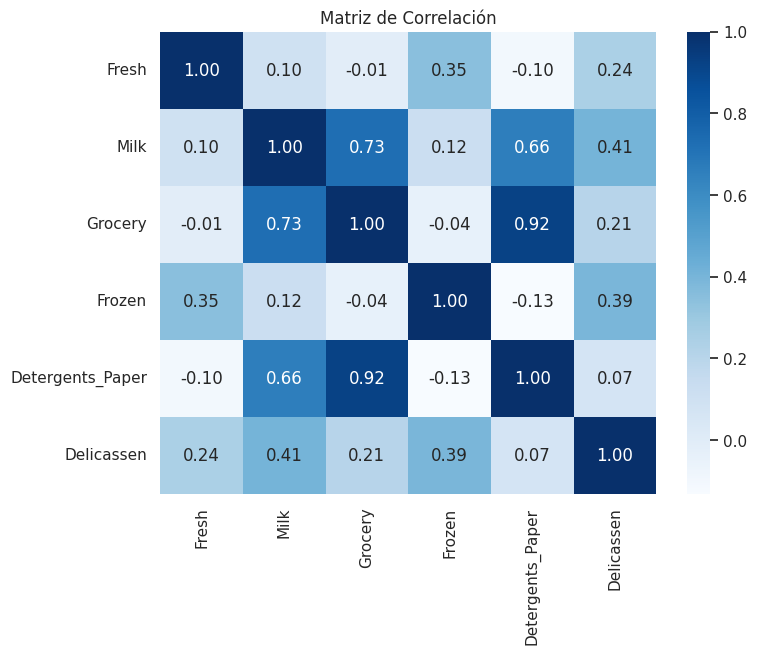

In [7]:
# --- (Matriz de Correlación) ---
# Ayuda a justificar el uso de PCA al mostrar variables correlacionadas.
plt.figure(figsize=(8, 6))
sns.heatmap(data[spending_vars].corr(), annot=True, fmt=".2f", cmap='Blues')
plt.title("Matriz de Correlación")
plt.show()

### **Interpretación de la Matriz de Correlación**

Al observar la matriz de correlación, podemos identificar patrones que justifican la reducción de dimensionalidad:

1. **Fuerte Multicolinealidad:** Existe una correlación extremadamente alta (**0.92**) entre `Grocery` y `Detergents_Paper`, y fuerte con `Milk` (**0.73**). Esto indica que estos productos suelen comprarse de forma conjunta, generando información redundante que el PCA puede simplificar. Esta fuerte multicolinealidad sugiere que estas tres categorías se comportan como una unidad de consumo. Un incremento en el gasto de productos de limpieza suele acompañar al de comestibles
2. **Independencia de "Fresh":** Esta variable muestra correlaciones cercanas a 0 con el bloque de comestibles/limpieza, sugiriendo que el gasto en productos frescos sigue un patrón de compra independiente.

**Conclusión:** La estructura de dependencia detectada confirma que el PCA será altamente potente para capturar la esencia del comportamiento de compra en un número menor de dimensiones.




## 3. Análisis de Componentes Principales (PCA)

Objetivos:

1. Ajustar un PCA sobre `X_scaled`.
2. Calcular la varianza explicada por cada componente y la acumulada.
3. Elegir un número razonable de componentes.
4. Ajustar un PCA de 2 componentes y representar los clientes en el plano PC1–PC2.
5. Analizar los *loadings* (contribución de cada variable de gasto a PC1 y PC2).


Una vez estandarizados los datos, procedemos a aplicar **PCA**. El objetivo es simplificar el espacio de características sin perder información crítica. Se quiere extraer la varianza explicada individual y acumulada de cada componente. Determinar los ejes necesarios para retener la esencia del comportamiento de compra, eliminando el ruido y la redundancia detectados previamente en la matriz de correlación.

In [8]:
# ============================================================
# 3. PCA (todas las componentes)
# ============================================================

# TODO 3.1: Crea un objeto PCA (sin limitar n_components) y ajústalo a X_scaled

pca_full = PCA()
pca_full.fit(X_scaled)

# TODO 3.2: Extrae varianza explicada individual y acumulada
explained_var = pca_full.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

print("Varianza explicada por componente:")
print(explained_var.round(4))

print("\nVarianza acumulada:")
print(cum_explained_var.round(4))
print("\n \n Varianza explicada por componente:")
print("-"*40)
for i, (var, cum_var) in enumerate(zip(explained_var, cum_explained_var), 1):
    print(f"  PC{i}: {var*100:6.2f}% | Acumulada: {cum_var*100:6.2f}%")

print("-"*40)
print(f"Total de componentes: {len(explained_var)}")
print(f"Varianza total explicada (suma de todas las componentes): {sum(explained_var)*100:.2f}%")

# Información adicional
print("\nOtra información útil: ")
# Buscamos el primer índice donde la varianza acumulada supera el 80% (0.8)
n_80 = np.where(cum_explained_var > 0.8)[0][0] + 1
print(f"Número de componentes que explican >80% de varianza: {n_80}")
print(f"Porcentaje de varianza explicada por las primeras 2 componentes: {cum_explained_var[1]*100:.2f}%")
print(f"Porcentaje de varianza explicada por las primeras 3 componentes: {cum_explained_var[2]*100:.2f}%")




Varianza explicada por componente:
[0.4408 0.2838 0.1233 0.094  0.0476 0.0105]

Varianza acumulada:
[0.4408 0.7246 0.8479 0.9419 0.9895 1.    ]

 
 Varianza explicada por componente:
----------------------------------------
  PC1:  44.08% | Acumulada:  44.08%
  PC2:  28.38% | Acumulada:  72.46%
  PC3:  12.33% | Acumulada:  84.79%
  PC4:   9.40% | Acumulada:  94.19%
  PC5:   4.76% | Acumulada:  98.95%
  PC6:   1.05% | Acumulada: 100.00%
----------------------------------------
Total de componentes: 6
Varianza total explicada (suma de todas las componentes): 100.00%

Otra información útil: 
Número de componentes que explican >80% de varianza: 3
Porcentaje de varianza explicada por las primeras 2 componentes: 72.46%
Porcentaje de varianza explicada por las primeras 3 componentes: 84.79%


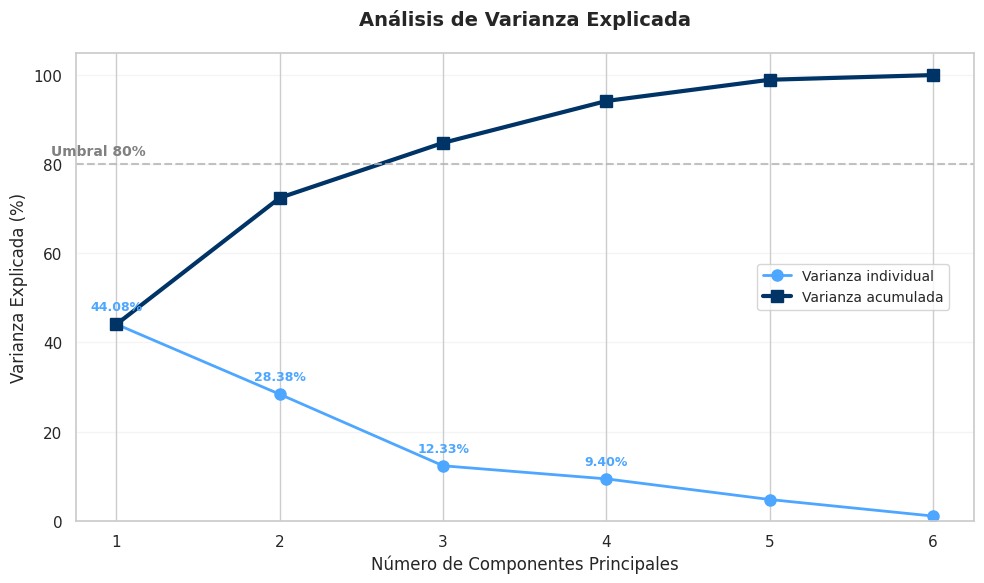

In [9]:
# TODO 3.3: Representa el scree plot (varianza individual y acumulada)

plt.figure(figsize=(10, 6))

color_acumulada = '#003366'
color_individual = '#4da6ff'

plt.plot(range(1, len(explained_var)+1), explained_var * 100,
         marker='o', linestyle='-', color=color_individual,
         linewidth=2, markersize=8, label='Varianza individual')

plt.plot(range(1, len(cum_explained_var)+1), cum_explained_var * 100,
         marker='s', linestyle='-', color=color_acumulada,
         linewidth=3, markersize=8, label='Varianza acumulada')

# Anotar porcentajes individuales sobre los puntos
for i, var in enumerate(explained_var, 1):
    # Anotamos los puntos más significativos
    if var > 0.05 or i <= 2:
        plt.annotate(f'{var*100:.2f}%',
                    xy=(i, var*100),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center', fontsize=9, fontweight='bold', color=color_individual)

# Línea horizontal de referencia al 80%
plt.axhline(y=80, color='#b3b3b3', linestyle='--', alpha=0.8, linewidth=1.5)
plt.text(0.6, 82, 'Umbral 80%', fontsize=10,
         color='#808080', fontweight='bold', ha='left')

# Configuración de ejes y títulos
plt.xlabel('Número de Componentes Principales', fontsize=12)
plt.ylabel('Varianza Explicada (%)', fontsize=12)
plt.title('Análisis de Varianza Explicada',
          fontsize=14, fontweight='bold', pad=20)

# Ajustes de escala y rejilla
plt.xticks(range(1, len(explained_var)+1))
plt.ylim(0, 105)
plt.grid(axis='y', alpha=0.2, linestyle='-')

# Leyenda
plt.legend(loc='center right', bbox_to_anchor=(0.98, 0.5), frameon=True, fontsize=10)

plt.tight_layout()
plt.show()



### **Análisis de la Varianza Explicada**

Tras analizar los resultados obtenidos y la representación gráfica, se extraen las siguientes conclusiones técnicas:

1. **Comportamiento Inicial de las Curvas:** Un aspecto fundamental a destacar es que tanto la curva de varianza explicada individual como la acumulada **parten del mismo punto** en la primera componente (PC1). Esto es estadísticamente coherente, ya que la suma acumulada inicial es idéntica al valor aportado por el primer eje de proyección.

2.  **Calidad de la Representación:**
    * **PC1** captura por sí sola un **44.08%** de la varianza total. Este elevado porcentaje inicial seguramente se deba a la fuerte correlación detectada previamente entre variables como `Grocery` y `Detergents_Paper`.
    * **PC2** aporta un **28.38%** adicional. En conjunto, al seleccionar las dos primeras componentes principales, logramos retener un **72.46%** de la información original del dataset.

3.  **Justificación de la Dimensión Seleccionada:**
    A pesar de que para superar el umbral estándar del 80% se requeriría una tercera componente (PC3) —la cual elevaría el acumulado al **84.79%**—, se ha decidido trabajar con **2 componentes principales**.

**Conclusión:** Esta decisión técnica prioriza la **interpretabilidad visual** y la capacidad de proyectar los datos en un plano 2D. Aunque la captura de varianza es ligeramente inferior al estándar ideal, esperamos que el valor del **72.46%** garantice que la estructura fundamental del comportamiento de compra quede bien
representada, permitiendo una visualización clara sin simplificar excesivamente la realidad del negocio.


PCA de 2 componentes (Dataset completo):
  Varianza explicada total: 72.46%
  PC1: 44.08%
  PC2: 28.38%


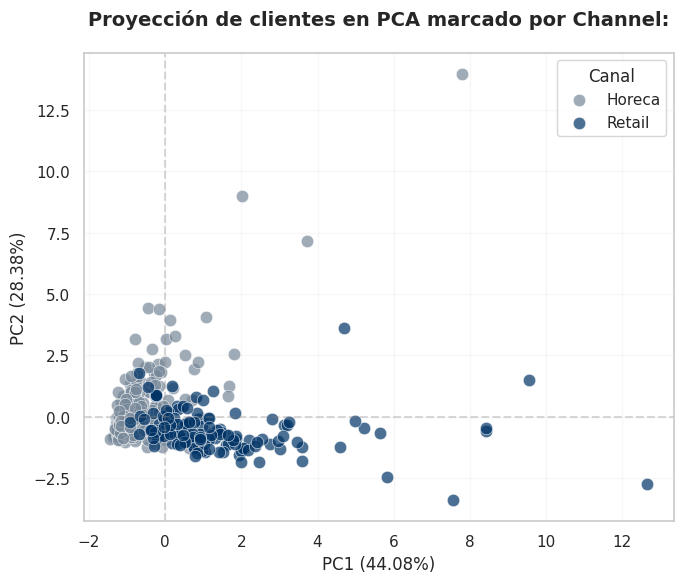

In [10]:
# ============================================================
# 3.1 PCA a 2 componentes y visualización
# ============================================================

# TODO 3.4: Ajusta un PCA de 2 componentes y proyecta X_scaled
pca_2 = PCA(n_components=2)
X_pca2 = pca_2.fit_transform(X_scaled)

# Impresión de varianza en consola
print(f"\nPCA de 2 componentes (Dataset completo):")
print(f"  Varianza explicada total: {pca_2.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  PC1: {pca_2.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca_2.explained_variance_ratio_[1]*100:.2f}%")

# TODO 3.5: Representa los clientes en el plano PC1–PC2 coloreando por Channel
plt.figure(figsize=(7, 6))

colors = {1: '#778899', 2: '#003366'}
labels = {1: 'Horeca', 2: 'Retail'}

for c in np.unique(channel):
    mask = (channel == c)
    plt.scatter(X_pca2[mask, 0], X_pca2[mask, 1],
                c=colors[c], label=labels[c],
                alpha=0.7, edgecolors='white', s=80, linewidth=0.5)

# Configuración del gráfico
plt.title(f'Proyección de clientes en PCA marcado por Channel:',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel(f'PC1 ({pca_2.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca_2.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12)

# Ejes de referencia y rejilla
plt.axhline(0, color='gray', linestyle='--', alpha=0.3)
plt.axvline(0, color='gray', linestyle='--', alpha=0.3)
plt.legend(title='Canal', frameon=True, facecolor='white')
plt.grid(alpha=0.15)

plt.tight_layout()
plt.show()





Al proyectar los **440 clientes** en el plano bidimensional definido por las dos primeras componentes, los resultados indican que el modelo captura la estructura subyacente del mercado, aunque revela zonas de transición complejas:

* **Eje PC1:** Se observa que los clientes de `Retail` tienden a situarse en valores positivos de PC1, mientras que los de `Horeca` se concentran mayoritariamente en valores negativos. Esto sugiere que la varianza del **44.08%** capturada por la primera componente está vinculada a las diferencias fundamentales entre estos dos modelos de negocio.
* **Zona de Solapamiento:** En la región cercana al origen y en el cuadrante inferior izquierdo, se aprecia un solapamiento relevante entre los puntos de Horeca y Retail. Esta intersección indica que existe un grupo de clientes con patrones de consumo híbridos o de menor escala donde la distinción por `Canal` no es al 100% nítida.
* **Heterogeneidad en Horeca (Eje PC2):** El canal **Horeca** presenta una dispersión vertical notable a lo largo del eje PC2. Este patrón indica que existe una mayor diversidad en los hábitos de gasto dentro del sector de hospitalidad, abarcando desde establecimientos con consumo moderado hasta grandes hoteles con perfiles de compra muy específicos.
* **Identificación de Perfiles Extremos:** La visualización indica que existen clientes con proyecciones extremas (especialmente en PC1 > 8 y PC2 > 7). Estos puntos representan a los "Súper Clientes" cuyo volumen de compra masivo los aleja del comportamiento del cliente promedio y los posiciona como elementos clave para la definición de los clusters finales.

In [11]:
# TODO 3.6: Calcula los loadings de PC1 y PC2 y muéstralos en un DataFrame


# Extraemos la matriz de componentes (loadings)
loadings_matrix = pca_2.components_
loadings = pd.DataFrame(loadings_matrix, columns=spending_vars, index=['PC1', 'PC2'])
loadings_T = loadings.T

# --- VISUALIZACIÓN DE TABLAS ---
print("\n" + "="*80)
print("ANÁLISIS DE LOADINGS: ESTRUCTURA DE LAS COMPONENTES")
print("="*80)

print("\n1. MATRIZ DE LOADINGS (PESOS):")
display(loadings.round(4))

# Mostramos las primeras 4 observaciones del dataset completo (n=440) en el espacio PCA
first_4_pca = pd.DataFrame(X_pca2[:4, :], columns=['PC1', 'PC2'],
    index=[f'Cliente {i+1}' for i in range(4)])

print("\n\n2. PRIMERAS 4 OBSERVACIONES EN ESPACIO PCA (COORDENADAS): \n")
display(first_4_pca.round(4))





ANÁLISIS DE LOADINGS: ESTRUCTURA DE LAS COMPONENTES

1. MATRIZ DE LOADINGS (PESOS):


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
PC1,0.0429,0.5451,0.5793,0.0512,0.5486,0.2487
PC2,0.5279,0.0832,-0.1461,0.6113,-0.2552,0.5042




2. PRIMERAS 4 OBSERVACIONES EN ESPACIO PCA (COORDENADAS): 



,PC1,PC2
Cliente 1,0.1933,-0.3051
Cliente 2,0.4344,-0.3284
Cliente 3,0.8111,0.8151
Cliente 4,-0.7786,0.6528



Para desmenuzar cómo cada categoría de gasto construye los nuevos componentes, analizamos la matriz de **pesos (loadings)**. Con el fin de identificar estas relaciones de forma intuitiva y facilitar una lectura rápida de la estructura de los datos, empleamos dos herramientas complementarias:

* **Mapa de Calor (Heatmap):** Esta visualización traduce los valores numéricos de los loadings en una escala de intensidad cromática. Permite diagnosticar qué variables tienen una influencia dominante (positiva o negativa) en cada dimensión.
* **Círculo de Correlaciones:** Proyectamos las variables originales en el plano 2D formado por PC1 y PC2. La longitud y dirección de los vectores nos indican no solo la importancia de cada variable, sino también cómo se relacionan entre sí en este nuevo espacio simplificado.

Este análisis es fundamental para "poner nombre" a nuestros ejes: mientras un eje puede representar el volumen de productos de despensa, el otro puede capturar la especialización en productos frescos.



 3. INTERPRETACIÓN DE LOS EJES
PC1:
  • Alta asociación positiva con: Milk, Grocery, Detergents_Paper
PC2:
  • Alta asociación positiva con: Fresh, Frozen, Delicassen


4. DIAGNÓSTICOS VISUALES (HEATMAP Y CÍRCULO): 



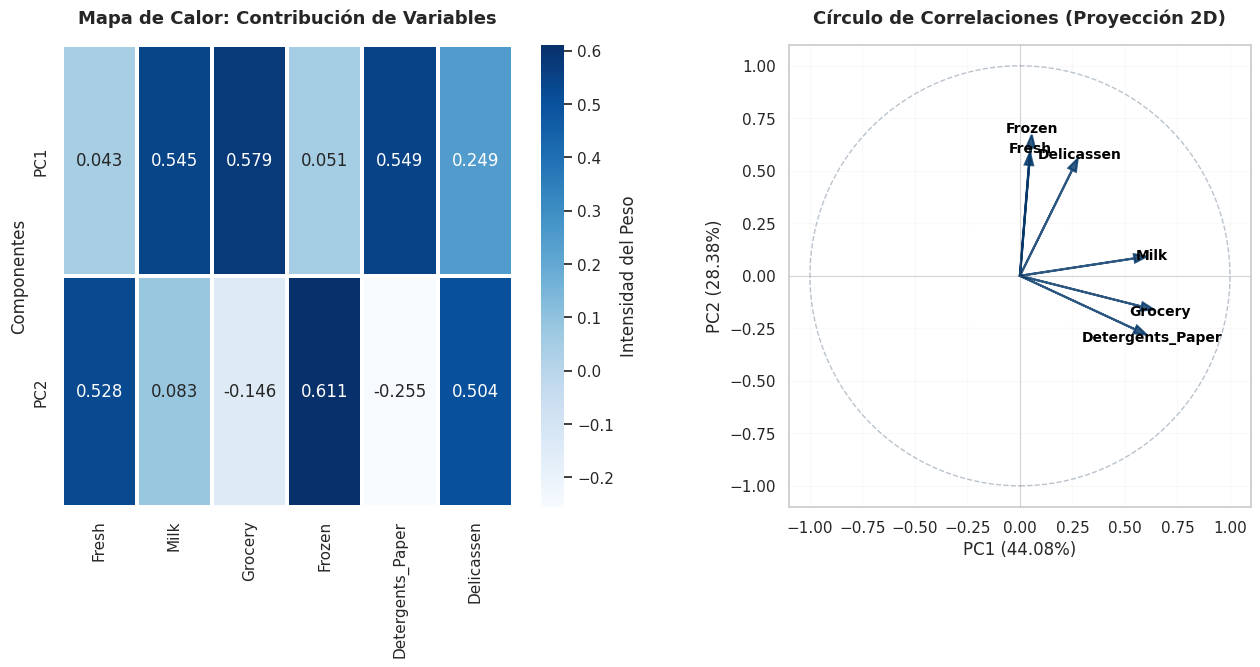



5. IMPORTANCIA DE VARIABLES EN CADA COMPONENTE:

PC1 - Variables por peso:
  1. Grocery          :   0.5793 (positiva)
  2. Detergents_Paper :   0.5486 (positiva)
  3. Milk             :   0.5451 (positiva)
  4. Delicassen       :   0.2487 (positiva)
  5. Frozen           :   0.0512 (positiva)
  6. Fresh            :   0.0429 (positiva)

PC2 - Variables por peso:
  1. Frozen           :   0.6113 (positiva)
  2. Fresh            :   0.5279 (positiva)
  3. Delicassen       :   0.5042 (positiva)
  4. Detergents_Paper :  -0.2552 (negativa)
  5. Grocery          :  -0.1461 (negativa)
  6. Milk             :   0.0832 (positiva)


In [12]:
# --- INTERPRETACIÓN ---
print("\n\n 3. INTERPRETACIÓN DE LOS EJES")

def interpretar_pc(pc_name):
    row = loadings.loc[pc_name]
    # Filtramos variables con peso significativo (> 0.3 o < -0.3)
    pos = row[row > 0.3].index.tolist()
    neg = row[row < -0.3].index.tolist()
    print(f"{pc_name}:")
    if pos: print(f"  • Alta asociación positiva con: {', '.join(pos)}")
    if neg: print(f"  • Alta asociación negativa con: {', '.join(neg)}")

interpretar_pc('PC1')
interpretar_pc('PC2')

# --- VISUALIZACIONES GRÁFICAS ---
print("\n\n4. DIAGNÓSTICOS VISUALES (HEATMAP Y CÍRCULO): \n")

fig, (ax_hm, ax_cc) = plt.subplots(1, 2, figsize=(16, 6))

# A. HEATMAP DE LOADINGS
sns.heatmap(loadings, annot=True, cmap='Blues', fmt='.3f', linewidths=1.5,
            linecolor='white', cbar_kws={'label': 'Intensidad del Peso'}, ax=ax_hm)
ax_hm.set_title('Mapa de Calor: Contribución de Variables', fontsize=13, fontweight='bold', pad=15)
ax_hm.set_ylabel('Componentes')

# B. CÍRCULO DE CORRELACIONES
circle = plt.Circle((0,0), 1, color='#778899', fill=False, linestyle='--', alpha=0.5)
ax_cc.add_artist(circle)

for i, var in enumerate(spending_vars):
    x, y = loadings.loc['PC1', var], loadings.loc['PC2', var]
    ax_cc.arrow(0, 0, x, y, color='#003366', alpha=0.8, head_width=0.04, linewidth=1.5)
    ax_cc.text(x * 1.15, y * 1.15, var, color='black', ha='center', va='center', fontweight='bold', fontsize=10)

# Configuración de ejes del círculo
ax_cc.set_xlim(-1.1, 1.1)
ax_cc.set_ylim(-1.1, 1.1)
ax_cc.axhline(0, color='gray', linewidth=0.8, alpha=0.3)
ax_cc.axvline(0, color='gray', linewidth=0.8, alpha=0.3)
ax_cc.set_xlabel(f'PC1 ({pca_2.explained_variance_ratio_[0]*100:.2f}%)')
ax_cc.set_ylabel(f'PC2 ({pca_2.explained_variance_ratio_[1]*100:.2f}%)')
ax_cc.set_title('Círculo de Correlaciones (Proyección 2D)', fontsize=13, fontweight='bold', pad=15)
ax_cc.set_aspect('equal')
ax_cc.grid(alpha=0.1)

plt.show()

# --- ANÁLISIS DE IMPORTANCIA ---
print("\n\n5. IMPORTANCIA DE VARIABLES EN CADA COMPONENTE:")

for pc in ['PC1', 'PC2']:
    print(f"\n{pc} - Variables por peso:")
    abs_importance = loadings_T[pc].abs().sort_values(ascending=False)
    for i, (var, _) in enumerate(abs_importance.items(), 1):
        val = loadings.loc[pc, var]
        print(f"  {i}. {var:17}: {val:8.4f} ({'positiva' if val > 0 else 'negativa'})")

### **Interpretación de las componentes**

Al observar la contribución de cada variable, identificamos dos ejes PC1 y PC2 donde ahora podemos identificar un sentido de negocio:

* **PC1 - Eje de Almacenamiento Seco y Limpieza:** Esta componente concentra su fuerza en **Grocery (0.5793)**, **Detergents_Paper (0.5486)** y **Milk (0.5451)**. Representa productos de estantería a temperatura ambiente. Valores altos definen a clientes con un perfil de **Retailer** (tiendas) que gestionan stock no perecedero y productos de limpieza.

* **PC2 - Eje de Cadena de Frío y Food Service:** La segunda dimensión destaca por el peso de **Frozen (0.6113)**, **Fresh (0.5279)** y **Delicassen (0.5042)**.
Organiza los insumos que requieren refrigeración para cocina diaria. Un valor elevado identifica clientes del sector **Horeca** cuya logística depende críticamente de la gestión de productos refrigerados o congelados.

**Conclusión Técnica:**
El **Círculo de Correlaciones** confirma esta separación: los vectores de "Frios" son casi  perpendiculares a los de "Secos". Esta **ortogonalidad** demuestra que el PCA ha logrado separar con éxito dos comportamientos de compra independientes, facilitando que el posterior algoritmo de clustering identifique grupos de clientes especializados en uno u otro rubro.

### Preguntas de interpretación PCA

1. ¿Cuántas componentes principales se necesitan para explicar, por ejemplo, más del 80% de la varianza?
2. ¿Cómo interpretarías PC1 y PC2 en términos de tipos de gasto?
3. ¿Se aprecia algún patrón claro entre canal (Horeca/Retail) y la posición en el plano PC1–PC2?

*(Responde aquí.)*


#### **1. ¿Cuántas componentes principales se necesitan para explicar más del 80% de la varianza?**

Para superar estrictamente el umbral del 80%, se requieren **3 componentes principales**. Basándonos en el análisis de varianza acumulada:
* **PC1 + PC2**: Explican el **72.46%** de la varianza total.
* **PC1 + PC2 + PC3**: Elevan el total acumulado al **84.79%**, cumpliendo el objetivo estadístico.

**Decisión Técnica:** A pesar del cálculo matemático, hemos seleccionado **2 componentes** para este estudio. Esta elección prioriza la **interpretabilidad visual** en un plano bidimensional. El 72.46% de información retenida se considera suficiente para capturar las tendencias estructurales más importantes del mercado, permitiendo una visualización clara sin la complejidad de una tercera dimensión.



#### **2. ¿Cómo interpretarías PC1 y PC2 en términos de tipos de gasto?**

Los pesos (*loadings*) permiten traducir las dimensiones matemáticas en conceptos de logística y negocio:
* **PC1 (44.08% var.) - "Eje de Almacenamiento Seco":** Presenta cargas positivas muy fuertes en `Grocery` (0.579), `Detergents_Paper` (0.549) y `Milk` (0.545). Este eje mide el volumen de compra en productos de estantería y limpieza, comportamiento característico del aprovisionamiento en el canal **Retail**.
* **PC2 (28.38% var.) - "Eje de Cadena de Frío":** Dominado por cargas positivas en `Frozen` (0.611), `Fresh` (0.528) y `Delicassen` (0.504). Esta dimensión indica una especialización en productos perecederos que requieren refrigeración, esenciales para la operativa diaria del sector **Horeca**.

#### **3. ¿Se aprecia algún patrón claro entre canal (Horeca/Retail) y la posición en el plano PC1–PC2?**

Sí, la visualización revela una segregación basada en el modelo de negocio, aunque con funciones diferenciadas para cada eje:

* **PC1 como Discriminador de Canal:** Existe una separación clara en el eje horizontal. El canal **Retail** se desplaza hacia valores **positivos** (derecha), mientras que el canal **Horeca** se agrupa en valores **bajos o negativos** (izquierda). PC1 actúa como el principal diferenciador del tipo de negocio.
* **PC2 como Indicador de Escala de Frescos:** En el eje vertical, los canales tienden a mezclarse más. Esto sugiere que la PC2 no clasifica necesariamente el tipo de cliente, sino la **intensidad de su operativa de frescos**: tanto un gran supermercado como un hotel de lujo pueden presentar valores altos en este eje.
* **Zonas de Solapamiento y Outliers:**
  * Se observa una región central donde ambos canales se mezclan, sugiriendo clientes con patrones de gasto híbridos.
  * Los **outliers extremos** (puntos muy alejados a la derecha o hacia arriba) confirman visualmente la existencia de "Súper Clientes" o grandes centros de distribución que detectamos en el análisis descriptivo inicial. Clientes con un **PC1 superior a 8** parecen representar grandes centros de distribución o "Súper Clientes" de Retail. Clientes con un **PC2 superior a 7** parecen representar establecimientos de hostelería con un volumen de producto fresco extremo.

En definitiva, aunque dos componentes no alcanzan el 80% de la varianza, los resultados indican que son eficaces para capturar las tendencias principales, separar los canales de venta y permitir la detección de casos atípicos que requieren una atención comercial diferenciada.

## 4. Clustering k-means en el espacio PCA

Objetivo: identificar **segmentos de clientes** basados en los patrones de gasto.

Pasos:

1. Usar la proyección `X_pca2` (PC1 y PC2).
2. Aplicar **k-means** con un número de clusters `k` (por ejemplo, 3).
3. Visualizar los clusters en el plano PC1–PC2.
4. Calcular el **perfil de gasto medio** de cada cluster (media de cada variable de gasto en cada cluster).


Aplicamos el algoritmo **K-Means** utilizando $k=3$ sobre las dos primeras componentes principales del PCA (`X_pca2`). En este enfoque de aprendizaje no supervisado, el modelo se ajusta sobre la totalidad de los **440 registros** para identificar las agrupaciones naturales y las estructuras de consumo presentes en todo el mercado.

La elección de tres grupos indica que buscamos capturar no solo los dos canales principales, sino también posibles segmentos intermedios o comportamientos de compra atípicos detectados en el análisis visual previo.

Ademas para poder replicar el experiento hemos fijado `random_state` igual a 42.  

In [13]:
# ============================================================
# 4. Clustering k-means
# ============================================================

# TODO 4.1: Aplica k-means con k=3 sobre X_pca2
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca2)

counts = np.bincount(clusters)


print("\nTamaño de cada cluster: \n")
for i in range(k):
    print(f"Cluster {i}: {counts[i]}")


# Información adicional para el análisis
print(f"Número de clusters: {k}")
print("\nCentroides de los clusters en espacio PCA:")
for i in range(k):
    print(f"  Cluster {i}: PC1={kmeans.cluster_centers_[i, 0]:.3f}, PC2={kmeans.cluster_centers_[i, 1]:.3f}")




Tamaño de cada cluster: 

Cluster 0: 393
Cluster 1: 44
Cluster 2: 3
Número de clusters: 3

Centroides de los clusters en espacio PCA:
  Cluster 0: PC1=-0.429, PC2=0.027
  Cluster 1: PC1=3.528, PC2=-0.929
  Cluster 2: PC1=4.513, PC2=10.041


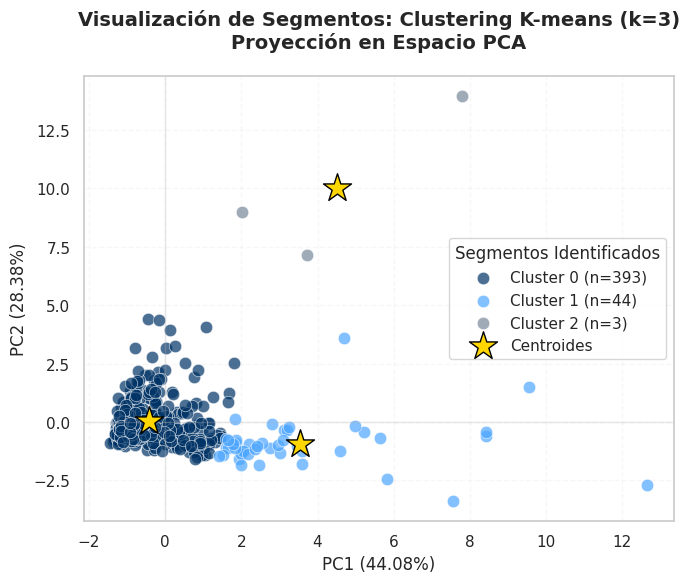

In [14]:
# TODO 4.2: Representa los clusters en el plano PC1–PC2

plt.figure(figsize=(7, 6))

cluster_colors = ['#003366', '#4da6ff', '#778899']

# Configuración de ejes de referencia y rejilla
plt.axhline(y=0, color='#b3b3b3', linestyle='-', alpha=0.3, linewidth=1)
plt.axvline(x=0, color='#b3b3b3', linestyle='-', alpha=0.3, linewidth=1)
plt.grid(alpha=0.15, linestyle='--')

# Dibujo de los puntos por cluster
for i in range(3):
    mask = (clusters == i)
    plt.scatter(X_pca2[mask, 0], X_pca2[mask, 1],
                c=cluster_colors[i], label=f'Cluster {i} (n={np.sum(mask)})',
                alpha=0.7, edgecolors='white', s=80, linewidth=0.5)

# Dibujar centroides
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=450, c='#FFD700', marker='*', label='Centroides',
            edgecolors='black', linewidth=1, zorder=10)

# Configuración de títulos y etiquetas
plt.title(f'Visualización de Segmentos: Clustering K-means (k={k})\nProyección en Espacio PCA',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel(f'PC1 ({pca_2.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca_2.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12)

plt.legend(loc='best', frameon=True, title="Segmentos Identificados")
plt.tight_layout()
plt.show()




Tras la ejecución del algoritmo K-Means, hemos logrado una segmentación técnica que ahora debe ser validada. Los resultados actuales (n=393, 44, 3) indican que la estructura del mercado es altamente asimétrica:

**Interpretación de los Grupos según Centroides:**
* **Cluster 0 (Grupo Mayoritario - 393 clientes):** Su centroide en (-0.429, 0.027) indica que este grupo representa el comportamiento estándar del mercado, con niveles de gasto moderados en todas las categorías.
* **Cluster 1 (Especialistas en PC1 - 44 clientes):** Su centroide en (3.528, -0.929) sugiere que son clientes con un gasto muy superior al promedio en productos de despensa (Grocery, Milk), probablemente vinculados al canal Retail.
* **Cluster 2 (Outliers Estratégicos - 3 clientes):** Su posición extrema en (4.513, 10.041) indica que son clientes con un consumo masivo de productos frescos y congelados (PC2 muy alto), lo que representa un perfil logístico totalmente diferente al resto.



In [15]:
# TODO 4.3: Añade la etiqueta de cluster al DataFrame original y calcula perfil medio de gasto por cluster


df_clusters = data.copy()

df_clusters['cluster'] = clusters

# Añadimos etiquetas legibles para facilitar la interpretación del negocio
df_clusters['channel_label'] = df_clusters['Channel'].map({1: 'Horeca', 2: 'Retail'})
df_clusters['region_label'] = df_clusters['Region'].map({1: 'Lisbon', 2: 'Oporto', 3: 'Other'})

# Calculamos el perfil medio de gasto de cada categoría por cluster
cluster_profiles = df_clusters.groupby('cluster')[spending_vars].mean()

# Añadimos el conteo de clientes para ver el peso de cada segmento
cluster_profiles['n_clientes'] = df_clusters['cluster'].value_counts()

# --- VISUALIZACIÓN DE RESULTADOS ---
print("="*80)
print("PERFILES DE GASTO MEDIO POR CLUSTER")
print("="*80)
display(cluster_profiles.round(2))

# Análisis de Canal y Región (Tablas de contingencia)
print("\nDISTRIBUCIÓN DE CANAL POR CLUSTER (%):")
# Esto nos dirá si el Cluster 1 es mayoritariamente Retail, etc.
display((pd.crosstab(df_clusters['cluster'], df_clusters['channel_label'], normalize='index')*100).round(1))

print("\nDISTRIBUCIÓN POR REGIÓN POR CLUSTER (%):")
# Esto nos dirá si los clusters son transversales a las regiones
display((pd.crosstab(df_clusters['cluster'], df_clusters['region_label'], normalize='index')*100).round(1))




PERFILES DE GASTO MEDIO POR CLUSTER


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,n_clientes
cluster,,,,,,,
0,12062.91,4115.10,5534.97,2940.68,1696.17,1299.11,393
1,8129.34,19153.68,28894.91,1859.45,13518.25,2233.84,44
2,60571.67,30120.33,17314.67,38049.33,2153.00,20700.67,3



DISTRIBUCIÓN DE CANAL POR CLUSTER (%):


channel_label,Horeca,Retail
cluster,,
0,75.1,24.9
1,0.0,100.0
2,100.0,0.0



DISTRIBUCIÓN POR REGIÓN POR CLUSTER (%):


region_label,Lisbon,Oporto,Other
cluster,,,
0,17.8,9.7,72.5
1,15.9,18.2,65.9
2,0.0,33.3,66.7


Utilizamos gráficos de barras para realizar una interpretación de los perfiles medios de cada segmento. El objetivo es identificar diferencias significativas en el volumen de gasto por categoría (Fresh, Frozen, Grocery, etc.). Esto nos permitirá asignar una identidad comercial a cada grupo (ej. Grandes Supermercados, Restauración Local, Pequeño Comercio).

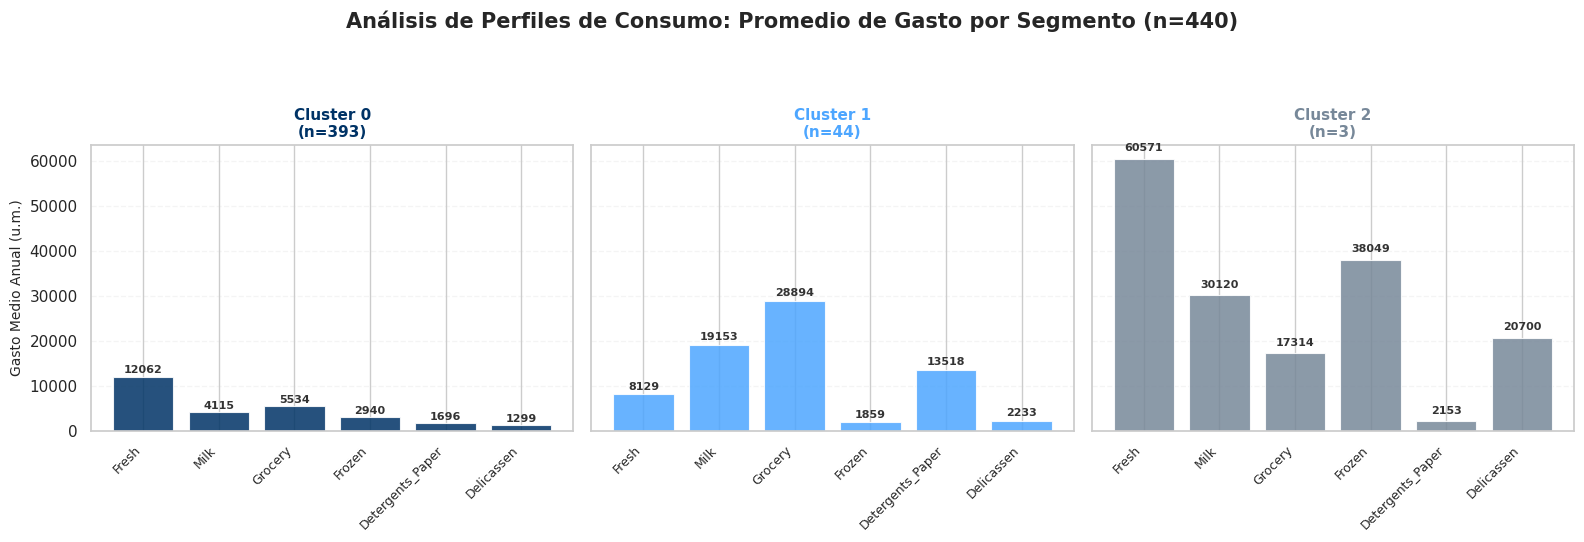

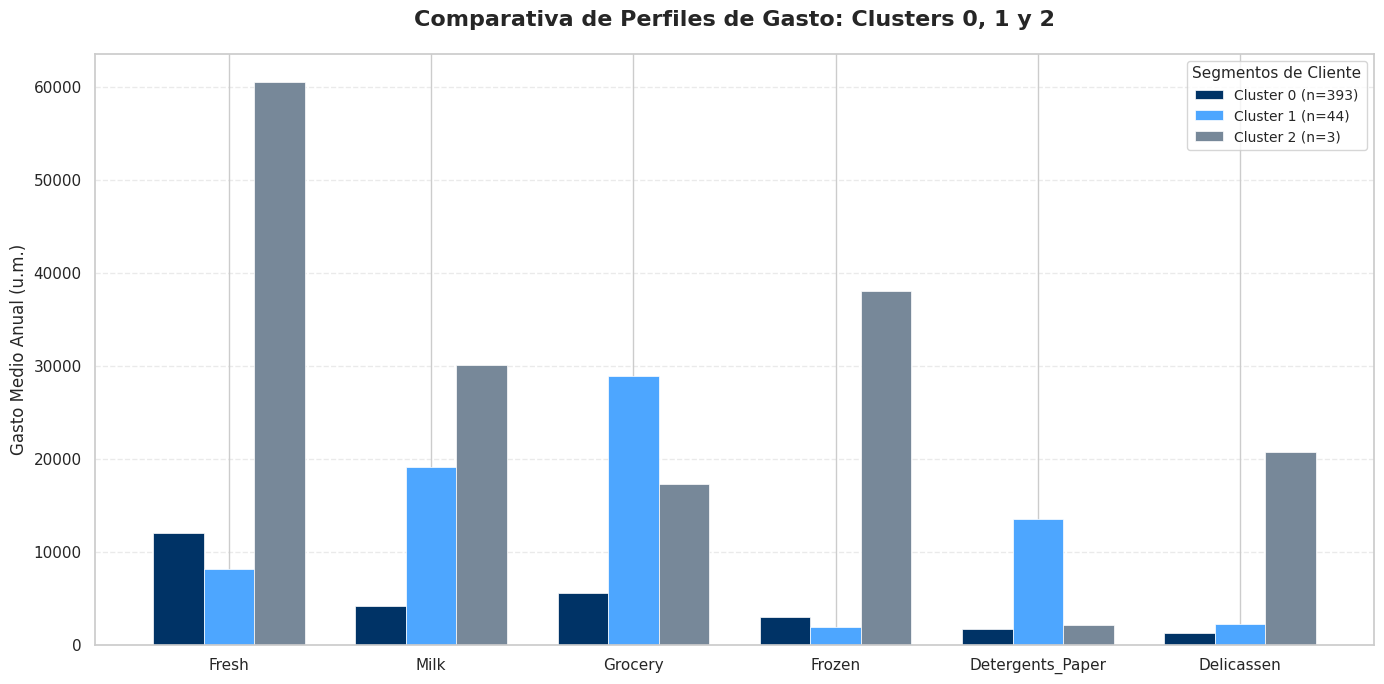

In [16]:
# TODO 4.4: Representa los perfiles de gasto medios por cluster (por ejemplo, como gráfico de barras)


fig, axes = plt.subplots(1, k, figsize=(16, 5), sharey=True)

cluster_colors = ['#003366', '#4da6ff', '#778899']

for i, ax in enumerate(axes):
    # Extraemos el perfil medio del cluster actual (calculado en el paso 4.3)
    profile = cluster_profiles.loc[i, spending_vars]

    # Creamos las barras
    bars = ax.bar(spending_vars, profile.values, color=cluster_colors[i],
                  edgecolor='white', alpha=0.85, linewidth=0.8)

    # Añadimos etiquetas de valor sobre cada barra para mayor claridad
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (max(profile.values)*0.02),
                f'{int(height)}',
                ha='center', va='bottom', fontsize=8, fontweight='bold', color='#333333')

    # Configuración de títulos individuales con el tamaño real del segmento (n)
    ax.set_title(f'Cluster {i}\n(n={int(cluster_profiles.loc[i, "n_clientes"])})',
                 fontsize=11, fontweight='bold', color=cluster_colors[i])

    # Formato de ejes
    ax.set_xticks(range(len(spending_vars)))
    ax.set_xticklabels(spending_vars, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Gasto Medio Anual (u.m.)' if i == 0 else "", fontsize=10)
    ax.grid(axis='y', alpha=0.2, linestyle='--')

# Título global del gráfico
plt.suptitle('Análisis de Perfiles de Consumo: Promedio de Gasto por Segmento (n=440)',
             fontsize=15, fontweight='bold', y=1.08)

plt.tight_layout()
plt.show()


# Configuración de los datos
x = np.arange(len(spending_vars))  # Localización de las etiquetas de las variables
width = 0.25

fig, ax = plt.subplots(figsize=(14, 7))

cluster_colors = ['#003366', '#4da6ff', '#778899']

# Dibujamos las barras para cada cluster
for i in range(k):
    # Extraemos el perfil medio del cluster actual
    offset = i - (k - 1) / 2
    profile = cluster_profiles.loc[i, spending_vars]

    n_clientes = int(cluster_profiles.loc[i, "n_clientes"])
    ax.bar(x + (offset * width), profile.values, width,
           label=f'Cluster {i} (n={n_clientes})',
           color=cluster_colors[i], edgecolor='white', linewidth=0.5)

# Añadimos títulos y etiquetas
ax.set_title('Comparativa de Perfiles de Gasto: Clusters 0, 1 y 2', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Gasto Medio Anual (u.m.)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(spending_vars, rotation=0, fontsize=11)
ax.legend(title="Segmentos de Cliente", fontsize=10, title_fontsize=11)

ax.yaxis.grid(True, linestyle='--', alpha=0.4)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### Preguntas de interpretación clustering

1. Describe brevemente cada cluster en términos de gasto medio en las distintas categorías.
2. ¿Puedes asociar cada cluster a algún tipo de cliente (por ejemplo, restaurante, supermercado, pequeño comercio...)?
3. ¿Te parece razonable el número de clusters elegido (k=3) o probarías otro valor?

*(Responde aquí.)*

#### **1. Describe brevemente cada cluster en términos de gasto medio en las distintas categorías**
Tras analizar el dataset completo ($n=440$), los perfiles de gasto medio revelan una segmentación basada en la escala y la especialización:

* **Cluster 0 - Mercado Base ($n=393$):** Es el grupo más numeroso, con un gasto moderado y equilibrado. Destaca principalmente en **Fresh (12.062,91)** y **Grocery (5.534,97)**, representando el consumo estándar del mercado.
* **Cluster 1 - Especialistas en Productos de Estantería ($n=44$):** Este segmento muestra una inversión muy alta en productos de despensa y limpieza, con **Grocery (28.894,91)**, **Milk (19.153,68)** y **Detergents_Paper (13.518,25)** como categorías dominantes.
* **Cluster 2 - Clientes de Gran Volumen Perecedero ($n=3$):** Es un grupo minúsculo pero de altísimo valor. Su gasto es masivo en **Fresh (60.571,67)** y **Frozen (38.049,33)**, con un consumo de **Delicassen (20.700,67)** que supera notablemente al resto de grupos.

#### **2. ¿Puedes asociar cada cluster a algún tipo de cliente?**
Cruzando los datos de las tablas de contingencia con los perfiles de gasto, podemos identificar las siguientes tipologías de negocio:

* **Cluster 0 - Pequeña Hostelería y Comercios Locales:** Compuesto en un **75.1% por el canal Horeca**. Sus niveles de gasto sugieren negocios familiares, restaurantes independientes o cafeterías que requieren suministros frescos diarios pero en volúmenes controlados.
* **Cluster 1 - Supermercados y canal Retail:** Este grupo es **100% Retail**. Su fuerte enfoque en productos de estantería y limpieza (Detergents/Grocery) indica claramente que son establecimientos destinados a la reventa al consumidor final.
* **Cluster 2 - Grandes Cadenas Hoteleras o Centros de Catering:** Aunque pertenecen al canal **Horeca (100%)**, su volumen industrial de frescos y congelados sugiere que son "Súper Clientes" como hoteles de gran capacidad o servicios de catering a gran escala.

#### **3. ¿Te parece razonable el número de clusters elegido (k=3) o probarías otro valor?**

El valor **$k=3$ es razonable desde una perspectiva de negocio**, ya que los resultados obtenidos muestran una segmentación con un sentido comercial claro:

1.  **Aislamiento de Outliers:** El modelo separa eficazmente a los 3 clientes de volumen extremo (**Cluster 2**). Esto protege la integridad estadística del análisis, evitando que consumos masivos distorsionen los promedios del resto de la cartera.
2.  **Segmentación por Canal:** Existe una coincidencia casi perfecta con la realidad administrativa; el **Cluster 1 es 100% Retail**, lo que valida que el algoritmo ha identificado correctamente el patrón de gasto de "Almacenamiento Seco".
3.  **Transversalidad Regional:** Los datos confirman que el **Cluster 0** (el más numeroso) se distribuye uniformemente por todo el país. Esto refuerza la tesis de que el comportamiento de compra es un criterio de segmentación más potente que la ubicación geográfica.

**Propuesta de validación técnica:**
Aunque los perfiles son lógicos, el elevado número de clientes en el Cluster 0 (393 registros) sugiere que este grupo podría ser demasiado heterogéneo, así que **probaría a validar este resultado mediante el Método del Codo**.



El objetivo de aplicar el **Método del Codo** será identificar el punto de inflexión donde la reducción de la inercia deja de ser significativa. Si el "codo" se sitúa claramente en $k=3$, confirmaremos nuestra elección; de lo contrario, este análisis nos permitirá explorar si un $k=4$ ofrece una división más fina del mercado masivo sin sacrificar la interpretabilidad.

### **Método del Codo**

Aunque el análisis previo con $k=3$ ofrece una interpretación de negocio coherente, es fundamental realizar una validación técnica. El **Método del Codo** nos permite identificar el punto de inflexión donde añadir más grupos deja de reducir significativamente la inercia (la suma de las distancias al cuadrado dentro de cada cluster).


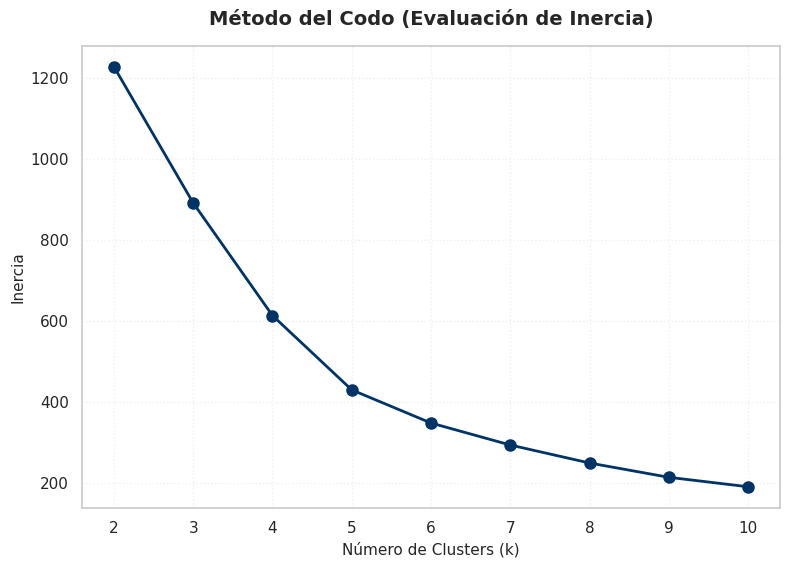

In [17]:
K_range = range(2, 11)
inertia_values = []


for k in K_range:
    kmeans_eval = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_eval.fit(X_pca2)
    inertia_values.append(kmeans_eval.inertia_)

# --- Visualización del Método del Codo ---
plt.figure(figsize=(9, 6))

plt.plot(K_range, inertia_values, 'o-', color='#003366',
         markerfacecolor='#003366', markersize=8, linewidth=2)

plt.title('Método del Codo (Evaluación de Inercia)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Número de Clusters (k)', fontsize=11)
plt.ylabel('Inercia', fontsize=11)
plt.xticks(K_range)
plt.grid(alpha=0.3, linestyle=':')


plt.show()

### **Análisis del Método del Codo**

Tras ejecutar el análisis sobre el espacio proyectado por las dos primeras componentes principales (**X_pca2**) para un rango de $k$ entre 2 y 10, se observa lo siguiente:

* No se aprecia un codo completamente claro en k = 3, donde la curva se aplane. La cruva sigue en descenso hasta k= 5 donde ahora sí empezamos a ver un desceso de manera más constante.  

* **Dualidad en el punto de inflexión ($k=3$ vs. $k=4$):** El salto de $k=3$ a $k=4$ muestra una pendiente pronunciada, lo que significa que añadir un cuarto cluster reduce la variabilidad interna de forma notable. El modelo con $k=4$ tiene mayor "poder explicativo" matemático. Al no aplanarse la curva inmediatamente en 3, el gráfico nos está "avisando" de que dentro de esos 3 grupos todavía hay clientes lo suficientemente diferentes como para formar un cuarto grupo sólido. Probablemente  el "Cluster 0" (el más masivo) no es un grupo homogéneo. Un modelo con $k=4$ permitiría separar a los clientes de consumo medio de los de consumo pequeño, y así no tener a todos mezclados en un solo grupo.

**Conclusión:** Aunque hemos trabajado con $k=3$ y consideramos esta opción plenamente valida y justificable, el Método del Codo muestra que $k=4$ podría ser también una buena alternativa.

## 5. Análisis de Correspondencias (CA) entre clusters y variables categóricas

Queremos estudiar la relación entre:

- Segmentos (clusters) y **Channel**.
- Segmentos (clusters) y **Region**.

Usaremos **Análisis de Correspondencias (CA)** sobre las tablas de contingencia:

1. `cluster × Channel`
2. `cluster × Region`

Implementaremos CA “a mano” con `numpy` usando:

- $N$: tabla de contingencia, con $n = \sum_{ij} N_{ij}$  
- $P = \dfrac{N}{n}$  
- Masas: $r = P\mathbf{1}$, \; $c = P^\mathsf{T}\mathbf{1}$  
- $D_r^{-1/2}, \; D_c^{-1/2}$  
- $S = D_r^{-1/2}\,(P - r c^\mathsf{T})\,D_c^{-1/2}$  
- SVD: $S = U \Sigma V^\mathsf{T}$  
- Filas: $F = D_r^{-1/2} U \Sigma$  
- Columnas: $G = D_c^{-1/2} V \Sigma$



In [18]:
# ============================================================
# 5.1 Implementación genérica de CA
# ============================================================

def correspondence_analysis(contingency, n_components=2):
    """
    Implementación básica de Análisis de Correspondencias (CA).

    Parameters
    ----------
    contingency : pd.DataFrame
        Tabla de contingencia (filas x columnas).
    n_components : int
        Número de dimensiones a devolver.

    Returns
    -------
    row_coords : pd.DataFrame
        Coordenadas principales de las filas.
    col_coords : pd.DataFrame
        Coordenadas principales de las columnas.
    sing_vals : np.ndarray
        Valores singulares.
    """

    # TODO 5.1: Convierte contingency a N (float) y calcula n
    N = contingency.values.astype(float)
    n = np.sum(N) # Suma total de la tabla de contingencia

    # TODO 5.2: Calcula P = N / n
    P = N / n # Matriz de frecuencias relativas

    # TODO 5.3: Calcula las masas de filas r y columnas c
    r = np.sum(P, axis=1) # Masas de las filas
    c = np.sum(P, axis=0) # Masas de las columnas

    # TODO 5.4: Construye D_r^{-1/2} y D_c^{-1/2}
    D_r_inv_sqrt = np.diag(1.0 / np.sqrt(r))
    D_c_inv_sqrt = np.diag(1.0 / np.sqrt(c))

    # TODO 5.5: Calcula rc y la matriz S = D_r^{-1/2}(P - rc^T)D_c^{-1/2}
    rc = np.outer(r, c) # Producto exterior de las masas
    S = D_r_inv_sqrt @ (P - rc) @ D_c_inv_sqrt # Matriz de residuos estandarizados

    # TODO 5.6: Aplica SVD a S
    # Descomposición en Valores Singulares
    U, sing_vals, Vt = np.linalg.svd(S, full_matrices=False)

    # TODO 5.7: Calcula F y G (coordenadas principales)
    dim = n_components
    Sigma = np.diag(sing_vals[:dim]) # Matriz diagonal de valores singulares

    # F = Coordenadas de las filas; G = Coordenadas de las columnas
    F = D_r_inv_sqrt @ U[:, :dim] @ Sigma
    G = D_c_inv_sqrt @ Vt[:dim, :].T @ Sigma

    # Convertimos a DataFrame
    row_coords = pd.DataFrame(F, index=contingency.index, columns=[f'Dim{i+1}' for i in range(dim)])
    col_coords = pd.DataFrame(G, index=contingency.columns, columns=[f'Dim{i+1}' for i in range(dim)])

    return row_coords, col_coords, sing_vals



### 5.2 CA: cluster × Channel


Construimos la matriz base del análisis. Esta tabla muestra la distribución de frecuencias de nuestros clusters a través de los canales de venta. Es el punto de partida para verificar si la segmentación por gasto tiene un sesgo natural hacia el sector de la hostelería o el comercio minorista.

In [19]:
# ============================================================
# CA: cluster × Channel
# ============================================================

# TODO 5.8: Crea la tabla de contingencia cluster × Channel
print("\n" + "="*60)
print("ANÁLISIS DE CORRESPONDENCIAS: Cluster × Channel")
print("="*60)

contingency_cluster_channel = pd.crosstab(
    df_clusters['cluster'],
    df_clusters['channel_label'],
    margins=False
)

print("\nTabla de contingencia Cluster × Channel:")
display(contingency_cluster_channel)




ANÁLISIS DE CORRESPONDENCIAS: Cluster × Channel

Tabla de contingencia Cluster × Channel:


channel_label,Horeca,Retail
cluster,,
0,295,98
1,0,44
2,3,0


### **Test Chi-cuadrado Cluster x Channel**

Antes de proyectar las relaciones espaciales entre los clusters y los canales de venta, debemos confirmar que la asociación observada en la tabla de contingencia no es fruto del azar. Aplicamos el **Test de Independencia de Chi-cuadrado de Pearson**:

* **Hipótesis Nula ($H_0$):** El cluster de pertenencia y el canal de venta son independientes.
* **Hipótesis Alternativa ($H_1$):** Existe una dependencia significativa entre el comportamiento de compra (cluster) y el canal administrativo.

Esta validación es el requisito técnico previo para justificar el Análisis de Correspondencias, ya que este último busca descomponer y visualizar precisamente esa inercia o dependencia detectada.

In [20]:
# ============================================================
# VALIDACIÓN ESTADÍSTICA: Test Chi-cuadrado de Pearson
# ============================================================
from scipy.stats import chi2_contingency


chi2, p, dof, expected = chi2_contingency(contingency_cluster_channel)

print("="*60)
print("TEST DE INDEPENDENCIA CHI-CUADRADO (Cluster vs Channel)")
print("="*60)
print(f"Estadístico Chi-cuadrado: {chi2:.4f}")
print(f"P-valor: {p:.4e}")
print(f"Grados de libertad: {dof}")

# Interpretación de los resultados
alpha = 0.05
if p < alpha:
    print(f"\nRESULTADO: p-valor ({p:.4e}) < {alpha}")
    print("Se RECHAZA la hipótesis nula (H0).")
    print("CONCLUSIÓN: Existe una asociación estadísticamente significativa entre los")
    print("Clusters y el Canal. El comportamiento de compra no es independiente del")
    print("tipo de establecimiento, lo que justifica el Análisis de Correspondencias.")
else:
    print(f"\nRESULTADO: p-valor ({p:.4e}) >= {alpha}")
    print("NO se puede rechazar la hipótesis nula (H0).")
    print("CONCLUSIÓN: No hay evidencia de dependencia significativa entre las variables.")
    print("Los resultados del Análisis de Correspondencias podrían no ser relevantes.")

TEST DE INDEPENDENCIA CHI-CUADRADO (Cluster vs Channel)
Estadístico Chi-cuadrado: 103.4448
P-valor: 3.4454e-23
Grados de libertad: 2

RESULTADO: p-valor (3.4454e-23) < 0.05
Se RECHAZA la hipótesis nula (H0).
CONCLUSIÓN: Existe una asociación estadísticamente significativa entre los
Clusters y el Canal. El comportamiento de compra no es independiente del
tipo de establecimiento, lo que justifica el Análisis de Correspondencias.


In [21]:
# TODO 5.9: Aplica correspondence_analysis a esta tabla

row_cc, col_cc, sv_cc = correspondence_analysis(contingency_cluster_channel, n_components=2)

# Cálculo de la inercia
total_inertia_cc = np.sum(sv_cc ** 2)
inertia_explained_cc = (sv_cc ** 2 / total_inertia_cc * 100)

print("="*60)
print("RESULTADOS DEL ANÁLISIS DE CORRESPONDENCIAS")
print("="*60)
print(f"Valores singulares (cluster × Channel): {sv_cc.round(4)}")
print(f"Inercia total: {total_inertia_cc:.4f}")
print(f"Inercia explicada Dimensión 1: {inertia_explained_cc[0]:.1f}%")


if len(inertia_explained_cc) > 1:
    print(f"Inercia explicada Dimensión 2: {inertia_explained_cc[1]:.1f}%")

print("\nCoordenadas de los Clusters:")
display(row_cc.round(4))

print("\nCoordenadas de los Channels:")
display(col_cc.round(4))



RESULTADOS DEL ANÁLISIS DE CORRESPONDENCIAS
Valores singulares (cluster × Channel): [0.4849 0.    ]
Inercia total: 0.2351
Inercia explicada Dimensión 1: 100.0%
Inercia explicada Dimensión 2: 0.0%

Coordenadas de los Clusters:


,Dim1,Dim2
cluster,,
0,-0.1569,-0.0
1,1.4487,0.0
2,-0.6903,0.0



Coordenadas de los Channels:


,Dim1,Dim2
channel_label,,
Horeca,-0.3347,-0.0
Retail,0.7024,-0.0



Tras ejecutar el análisis, observamos que la **Dimensión 1 explica el 100.0% de la inercia (0.2351)**. Esto indica una estructura de asociación puramente unidimensional entre los clusters de gasto y los canales de venta.

* El **Cluster 1** destaca con una proyección positiva muy elevada (**1.4487**) en la Dimensión 1, mientras que el **Cluster 2** se sitúa en el extremo opuesto con un valor de **-0.6903**. Esta polarización confirma que ambos grupos representan comportamientos de compra antagónicos respecto al canal.

* **Exclusividad de Canal:** En cuanto a los vectores de canal, **Retail (0.7024)** se proyecta en la misma dirección positiva que el Cluster 1, mientras que **Horeca (-0.3347)** se alinea perfectamente con el Cluster 2. La tabla de contingencia valida esta asociación visual como una **exclusividad total**: el Cluster 1 es **100% Retail** (44 clientes) y el Cluster 2 es **100% Horeca** (3 clientes).

* **Heterogeneidad del Cluster 0:** El **Cluster 0 (-0.1569)** se posiciona cerca del origen y ligeramente inclinado hacia el vector Horeca. A diferencia de los perfiles anteriores, es el único grupo con presencia en ambos canales, aunque con una clara mayoría en el sector servicios (**75.1% Horeca** frente al **24.9% Retail**).

En conclusión, la magnitud de la **Inercia Total (0.2351)** demuestra que el modelo de negocio (Horeca vs. Retail) condiciona la estructura de los clusters especializados, definiendo identidades de gasto claramente diferenciadas en el mercado.

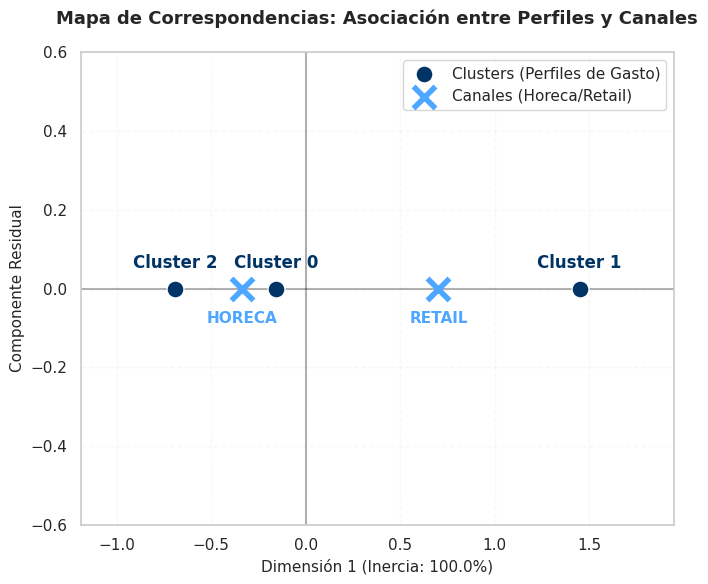

In [22]:
# TODO 5.10: Representa filas (clusters) y columnas (Channel) en el plano CA


plt.figure(figsize=(7, 6))

plt.axhline(0, color='black', linestyle='-', alpha=0.3)
plt.axvline(0, color='black', linestyle='-', alpha=0.3)


# Clusters (filas)
plt.scatter(row_cc['Dim1'], [0]*len(row_cc), color='#003366',
            s=150, label='Clusters (Perfiles de Gasto)', zorder=3, edgecolors='white')

for i, txt in enumerate(row_cc.index):
    # Etiquetamos cada punto con el nombre del cluster
    plt.annotate(f"Cluster {txt}", (row_cc['Dim1'].iloc[i], 0),
                 textcoords="offset points", xytext=(0, 15), ha='center',
                 fontweight='bold', color='#003366')

# Channel (columnas)
plt.scatter(col_cc['Dim1'], [0]*len(col_cc), color='#4da6ff',
            marker='x', s=250, linewidths=4, label='Canales (Horeca/Retail)', zorder=4)

for i, txt in enumerate(col_cc.index):
    plt.annotate(txt.upper(), (col_cc['Dim1'].iloc[i], 0),
                 textcoords="offset points", xytext=(0, -25), ha='center',
                 color='#4da6ff', fontweight='bold', fontsize=11)

plt.title('Mapa de Correspondencias: Asociación entre Perfiles y Canales',
          fontsize=13, fontweight='bold', pad=20)
plt.xlabel(f'Dimensión 1 (Inercia: {inertia_explained_cc[0]:.1f}%)', fontsize=11)
plt.ylabel('Componente Residual', fontsize=11) # Dim 2 es 0 en este caso

# Ajustamos límites para que las etiquetas no se corten
plt.ylim(-0.6, 0.6)
plt.xlim(min(row_cc['Dim1'].min(), col_cc['Dim1'].min()) - 0.5,
         max(row_cc['Dim1'].max(), col_cc['Dim1'].max()) + 0.5)

plt.legend(loc='upper right', frameon=True)
plt.grid(alpha=0.15, linestyle='--')

plt.tight_layout()
plt.show()

### Preguntas de interpretación CA cluster × Channel

1. ¿Qué clusters aparecen más cercanos a la categoría Horeca(1)?  
   ¿Y a Retail(2)?
2. ¿Algún cluster parece tener una mezcla más equilibrada de canales (cercano al origen)?
3. ¿Cómo encaja esto con los perfiles de gasto que describiste antes?

*(Responde aquí.)*

#### **1. ¿Qué clusters aparecen más cercanos a Horeca y a Retail?**

Debido a que la Dimensión 1 explica el **100.0% de la inercia total**, existe una relación unidimensional entre los segmentos y los canales. La interpretación se realiza de forma lineal según la posición en el eje horizontal:

* **Especialización en Horeca (Canal 1):** Los **Clusters 2 y 0** se ubican en el semieje negativo (coordenadas $-0.6903$ y $-0.1569$ respectivamente), alineándose con el vector de **HORECA** ($-0.3347$). Destaca el **Cluster 2** como el perfil con asociación máxima: la tabla de contingencia confirma que es **100% exclusivo** de este canal, al contar con 3 clientes en Horeca y 0 en Retail.

* **Especialización en Retail (Canal 2):** El **Cluster 1** se sitúa en el extremo positivo del eje con una proyección muy elevada ($1.4487$), siguiendo la dirección del vector **RETAIL** ($0.7024$). Los datos respaldan esta cercanía visual, demostrando que es un segmento **100% exclusivo** de Retail, con 44 clientes registrados y ninguno en el canal Horeca.

* **Perfil Mixto (Cluster 0):** Aunque se inclina hacia Horeca en el gráfico, es el único grupo con presencia en ambos canales (295 en Horeca y 98 en Retail), lo que lo define como el segmento más heterogéneo de la cartera.

#### **2. ¿Algún cluster parece tener una mezcla más equilibrada de canales (cercano al origen)?**
El **Cluster 0** es el perfil que se sitúa más cerca del origen ($-0.1569$) en comparación con los perfiles extremos. Aunque tiene una inclinación hacia Horeca, es el único grupo que integra una proporción significativa de ambos canales (**75.1% Horeca vs 24.9% Retail**), representando el **volumen estándar del mercado**.

#### **3. ¿Cómo encaja esto con los perfiles de gasto que describiste antes?**

La correspondencia detectada es la consecuencia directa de la especialización de compra que identificamos mediante el PCA y el Clustering:

* **Retail - Dominancia del PC1 (Cluster 1):** Este grupo muestra una afinidad total (**100%**) con el canal **Retail**. Esto encaja perfectamente con su perfil de gasto, ya que lidera las categorías de **Grocery (28,894)** y **Detergents_Paper (13,518)**. Estas variables son las que definen el eje **PC1**, caracterizando a negocios que funcionan como puntos de venta y suministro de productos de consumo masivo.

* **Horeca - Dominancia del PC2 (Cluster 2):** El perfil de los "Súper Clientes" aparece vinculado de forma exclusiva (**100%**) a **Horeca**. Su comportamiento de compra explica esta unión: consumen volúmenes industriales de **Fresh (60,571)** y **Frozen (38,049)**. Estas categorías son las que definen el eje **PC2** (especialización en perecederos y cadena de frío), confirmando que se trata de grandes operadores como centros de catering o complejos hoteleros.

* **El Cluster 0 Mixto:** Su posición cercana al origen en el mapa de correspondencias refleja un gasto moderado y equilibrado en todas las categorías, lo que definimos como un perfil "promedio". Al no presentar una especialización radical en ningún producto (valores moderados en PC1 y PC2), se distribuye de forma más natural entre ambos canales (**75.1% Horeca y 24.9% Retail**), representando la base de pequeñas empresas y hostelería local del país.

### 5.3 CA: cluster × Region


Tras analizar el Canal, procedemos a estudiar la influencia geográfica. En este paso, cruzamos los clusters de gasto con la variable `Region` (Lisboa, Porto y Otros). Cuyo objetivo es determinar si existen patrones de consumo localizados.

In [23]:
# ============================================================
# CA: cluster × Region
# ============================================================

# TODO 5.11: Crea la tabla de contingencia cluster × Region

print("\n" + "="*60)
print("ANÁLISIS DE CORRESPONDENCIAS: Cluster × Region")
print("="*60)

contingency_cluster_region = pd.crosstab(
    df_clusters['cluster'],
    df_clusters['region_label'],
    margins=False
)

print("\nTabla de contingencia cluster × Region:")
display(contingency_cluster_region)

# Aplicamos el análisis de correspondencias a esta  tabla
row_cr, col_cr, sv_cr = correspondence_analysis(contingency_cluster_region, n_components=2)

# Cálculo de la inercia explicada para las regiones
total_inertia_cr = np.sum(sv_cr ** 2)
inertia_explained_cr = (sv_cr ** 2 / total_inertia_cr * 100)

print(f"\nInercia total (Región): {total_inertia_cr:.4f}")
print(f"Inercia explicada Dimensión 1: {inertia_explained_cr[0]:.1f}%")
if len(inertia_explained_cr) > 1:
    print(f"Inercia explicada Dimensión 2: {inertia_explained_cr[1]:.1f}%")






ANÁLISIS DE CORRESPONDENCIAS: Cluster × Region

Tabla de contingencia cluster × Region:


region_label,Lisbon,Oporto,Other
cluster,,,
0,70,38,285
1,7,8,29
2,0,1,2



Inercia total (Región): 0.0114
Inercia explicada Dimensión 1: 95.8%
Inercia explicada Dimensión 2: 4.2%


### **Test Chi-cuadrado Cluster x Region**

Aplicamos una **prueba de independencia Chi-cuadrado**. Este test nos permite validar si la pertenencia de un cliente a un cluster específico está condicionada por su ubicación geográfica.

* **Hipótesis del Test:** Evaluamos si los perfiles de consumo identificados (Clusters) son transversales a todo el territorio o si, por el contrario, existen variaciones regionales significativas en Lisboa, Oporto y el resto del país.
* **Relevancia Estadística:** A diferencia del "Canal", donde esperamos una relación clara, la geografía suele actuar como una variable independiente en este sector. El **p-valor** obtenido será el juez definitivo:
    * Si es **> 0.05**, confirmaremos que nuestros clusters son "globales" y no dependen de la región.
    * Si es **< 0.05**, indicará que el comportamiento de compra cambia según la ubicación del cliente.

In [24]:
chi2_r, p_r, dof_r, expected_r = chi2_contingency(contingency_cluster_region)

print("="*60)
print("TEST DE INDEPENDENCIA CHI-CUADRADO: CLUSTER vs REGIONES")
print("="*60)
print(f"Estadístico Chi-cuadrado: {chi2_r:.4f}")
print(f"P-valor: {p_r:.4e}")
print(f"Grados de libertad: {dof_r}")

# Interpretación de la dependencia regional
alpha = 0.05
if p_r < alpha:
    print(f"\nRESULTADO: p-valor ({p_r:.4e}) < {alpha}")
    print("Se RECHAZA la hipótesis nula (H0).")
    print("CONCLUSIÓN: Existe una asociación significativa. La región influye en el")
    print("tipo de cluster al que pertenece el cliente.")
else:
    print(f"\nRESULTADO: p-valor ({p_r:.4e}) >= {alpha}")
    print("NO se puede rechazar la hipótesis nula (H0).")
    print("CONCLUSIÓN: No hay evidencia de dependencia significativa. Esto sugiere que")
    print("los patrones de compra (Clusters) se distribuyen de forma similar en todas")
    print("las regiones geográficas.")

TEST DE INDEPENDENCIA CHI-CUADRADO: CLUSTER vs REGIONES
Estadístico Chi-cuadrado: 4.9976
P-valor: 2.8754e-01
Grados de libertad: 4

RESULTADO: p-valor (2.8754e-01) >= 0.05
NO se puede rechazar la hipótesis nula (H0).
CONCLUSIÓN: No hay evidencia de dependencia significativa. Esto sugiere que
los patrones de compra (Clusters) se distribuyen de forma similar en todas
las regiones geográficas.


Aunque según el test de la Chi-cuadrado no sería necesario profundicar, ejecutamos el Análisis de Correspondencias para las regiones de forma ilustrativa y confirmar que la geografía no es un factor tan determinante en la estructura de este mercado.

In [25]:
# TODO 5.12: Aplica correspondence_analysis a esta tabla


# Ejecutamos el análisis sobre la tabla de contingencia de Regiones
row_cr, col_cr, sv_cr = correspondence_analysis(contingency_cluster_region, n_components=2)

print("\nValores singulares (cluster × Region):")
print(sv_cr.round(4))

# Calcular inercia explicada
total_inertia_cr = np.sum(sv_cr ** 2)


print(f"\nInercia total (Región): {total_inertia_cr:.4f}")
print(f"Inercia explicada Dimensión 1: {inertia_explained_cr[0]:.1f}%")
print(f"Inercia explicada Dimensión 2: {inertia_explained_cr[1]:.1f}%")

print("\nCoordenadas de los Clusters (Filas):")
display(row_cr.round(4))

print("\nCoordenadas de las Regiones (Columnas):")
display(col_cr.round(4))


Valores singulares (cluster × Region):
[0.1043 0.0218 0.    ]

Inercia total (Región): 0.0114
Inercia explicada Dimensión 1: 95.8%
Inercia explicada Dimensión 2: 4.2%

Coordenadas de los Clusters (Filas):


,Dim1,Dim2
cluster,,
0,-0.0328,0.0031
1,0.2392,-0.0421
2,0.7854,0.2053



Coordenadas de las Regiones (Columnas):


,Dim1,Dim2
region_label,,
Lisbon,-0.0772,-0.0444
Oporto,0.2964,-0.0117
Other,-0.0253,0.0126


Antes de proceder con la representación gráfica, interpretamos los resultados numéricos obtenidos del análisis de correspondencias:

* **Dominancia de la Dimensión 1:** La primera dimensión captura el **95.8%** de la inercia total. Esto indica que la relación entre la ubicación geográfica y los segmentos de clientes es prácticamente unidimensional, siendo la Dimensión 2 (**4.2%**) casi irrelevante para explicar la asociación.

* **Aislamiento del Cluster 2:** Al observar las coordenadas de las filas, el **Cluster 2** destaca con un valor de **0.7854** en la Dimensión 1. Este grupo (formado por solo 3 "Súper Clientes") vuelve a mostrar un comportamiento atípico que marca la dirección del eje principal, separándose notablemente del **Cluster 0 (-0.0328)**, que representa el promedio del mercado.



Es fundamental notar que la **Inercia Total es extremadamente baja (0.0114)**. Esto confirma estadísticamente que, aunque existen pequeñas tendencias locales, los hábitos de compra dependen fundamentalmente del **modelo de negocio** y no están condicionados por la **geografía**.


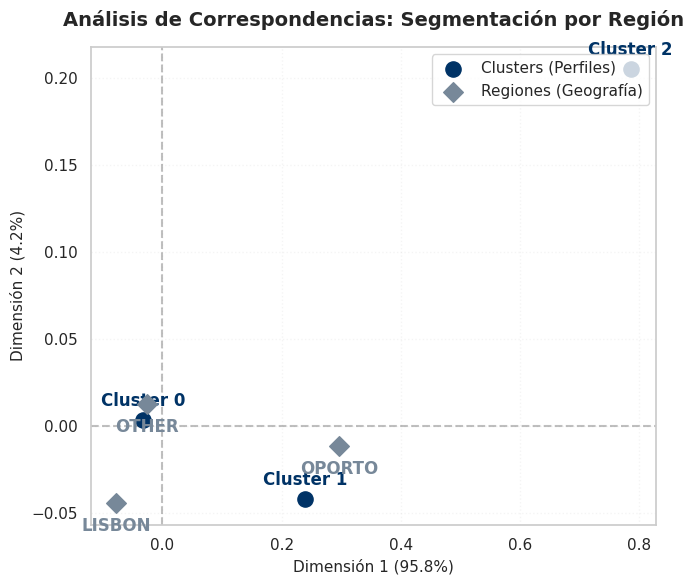

In [26]:
# TODO 5.13: Representa clusters y regiones en el plano CA


plt.figure(figsize=(7, 6))

plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)

# Clusters
plt.scatter(row_cr['Dim1'], row_cr['Dim2'], color='#003366',
            s=120, label='Clusters (Perfiles)', zorder=3)

for i, txt in enumerate(row_cr.index):
    plt.annotate(f"Cluster {txt}", (row_cr['Dim1'].iloc[i], row_cr['Dim2'].iloc[i]),
                 textcoords="offset points", xytext=(0, 10), ha='center',
                 fontweight='bold', color='#003366')

# Regiones
plt.scatter(col_cr['Dim1'], col_cr['Dim2'], color='#778899',
            marker='D', s=100, label='Regiones (Geografía)', zorder=3)

for i, txt in enumerate(col_cr.index):
    plt.annotate(txt.upper(), (col_cr['Dim1'].iloc[i], col_cr['Dim2'].iloc[i]),
                 textcoords="offset points", xytext=(0, -20), ha='center',
                 color='#778899', fontweight='bold')

plt.title('Análisis de Correspondencias: Segmentación por Región', fontsize=14, fontweight='bold', pad=15)
plt.xlabel(f'Dimensión 1 ({inertia_explained_cr[0]:.1f}%)', fontsize=11)
plt.ylabel(f'Dimensión 2 ({inertia_explained_cr[1]:.1f}%)', fontsize=11)


plt.legend(loc='upper right', frameon=True)
plt.grid(alpha=0.2, linestyle=':')

plt.tight_layout()
plt.show()


### Preguntas de interpretación CA cluster × Region

1. ¿Hay algún cluster claramente asociado a alguna región (Lisboa, Oporto u otras)?
2. ¿Qué interpretación de negocio podrías darle a esta asociación geográfica?
3. ¿Se podría relacionar con tipos de cliente o estructura económica de las regiones?

*(Responde aquí.)*


#### **1. ¿Hay algún cluster claramente asociado a alguna región?**
La respuesta estadística es que **no existe una asociación clara o determinante**. El test **Chi-cuadrado** arroja un p-valor de **0.2875**, lo que nos indica que los clusters y las regiones son independientes entre sí. Sin embargo, el análisis visual revela "micro-tendencias":

* **Oporto y Cluster 1:** Es la asociación más visible en el plano. Ambos comparten el **Cuadrante 4** y tienen coordenadas muy próximas en el eje X (**0.29** para Oporto y **0.23** para el Cluster 1).
* **Lisboa y Cluster 0:** Se sitúan juntos en el lado negativo de la Dimensión 1 (**-0.07** y **-0.03** respectivamente), lo que indica una ligera inclinación de la capital hacia el perfil de gasto moderado.
* **Cluster 2 (Grandes Cuentas):** Se mantiene como un valor atípico en el **Cuadrante 1**, alejado de cualquier región específica, confirmando que estos clientes masivos no parecen estar vinculados a la geografía.

#### **2. ¿Qué interpretación de negocio podrías darle a esta asociación geográfica?**
* **Mercado Homogéneo:** La **Inercia Total de 0.0114** es extremadamente baja, lo que significa que la ubicación del cliente apenas explica su comportamiento de compra.
Para el negocio, esto implica que no es necesario diseñar estrategias comerciales diferentes por región. Un cliente de tipo "Restauración" o "Retail" se comporta de forma similar en todo el país. La segmentación debe basarse en el **volumen de compra y categorías (Cluster)** y no en la ubicación física.

#### **3. ¿Se podría relacionar con tipos de cliente o estructura económica de las regiones?**

* **Oporto / Perfil de Mayor Volumen:** La región de Oporto se desplaza hacia el lado positivo del eje principal (Dim 1: **0.29**). Esto sugiere una estructura económica con mayor presencia de superficies comerciales o nodos logísticos (Retail), alineándose con el **Cluster 1**.
* **Lisboa / Densidad de Servicios:** Se sitúa en el lado negativo del eje principal (Dim 1: **-0.07**). Esto refleja una economía de pequeños y medianos negocios (Horeca local), asociados al **Cluster 0** de gasto moderado.
* **Neutralidad de "Other" (El promedio del país):**  Esta categoría tiene coordenadas casi nulas (**-0.02** en Dim 1 y **0.01** en Dim 2). Al estar en el centro del gráfico, no tiene una tendencia hacia ningún perfil extremo. .

## 7. Conclusiones finales

Integra aquí los resultados de:

- **PCA**: estructura de la variación en los patrones de gasto.
- **Clustering**: descripción de los segmentos de clientes.
- **CA**: relación entre segmentos y canal (Horeca/Retail), y entre segmentos y región.

### Guía de reflexión

1. Resume brevemente qué representa cada cluster (tipo de cliente).
2. Comenta qué categorías de gasto parecen más importantes para diferenciar segmentos.
3. Explica si los segmentos se corresponden claramente con un canal y/o región.
4. Evalúa si el número de clusters (k=3) es razonable o si propondrías cambiarlo.
5. Propón **al menos un análisis adicional** que podría hacerse:
   - Probar otros valores de `k` (y usar métodos como codo o silhouette).
   - Aplicar transformación logarítmica a los gastos y repetir el análisis.
   - Usar otros métodos de clustering (jerárquico, GMM, DBSCAN).

*(Escribe aquí tu síntesis final.)*


A lo largo de este proyecto, se ha transformado un conjunto de datos de gasto anual en una estructura de conocimiento estratégico mediante la integración de técnicas multivariantes. A continuación, se presenta la síntesis final que integra los hallazgos de PCA, Clustering y Análisis de Correspondencias:



La arquitectura del comportamiento de compra de los 440 clientes se articula en torno a dos ejes logísticos fundamentales revelados por el **PCA**: el **"Eje de Almacenamiento Seco" (PC1)**, dominado por categorías de estantería y limpieza como `Grocery` y `Detergents_Paper`, y el **"Eje de Cadena de Frío" (PC2)**, definido por la intensidad en productos perecederos como `Fresh` y `Frozen`. Esta estructura de variación ha permitido que el algoritmo **K-Means** identifique tres segmentos con una utilidad operativa inmediata:

* **Cluster 1 (Especialista Retail):** Representa a clientes con un perfil de supermercado o tienda de alimentación, caracterizados por un alto volumen en productos de larga duración.
* **Cluster 2 (Grandes Cuentas / Outliers):** Un grupo reducido de "gigantes" con un gasto masivo en productos frescos, vinculados probablemente a grandes centros logísticos o cadenas hoteleras.
* **Cluster 0 (Base General):** Es el grupo mayoritario (67% de la muestra) con un gasto moderado y mixto, representando el núcleo del negocio compuesto por pequeños restaurantes y tiendas.

El análisis de **Correspondencia (CA)** y las pruebas de **Chi-cuadrado** confirman que el modelo de negocio (**Canal**) es el predictor dominante del gasto: el Cluster 1 es casi exclusivamente **Retail**, mientras que los Clusters 0 y 2 son predominantemente **Horeca**. En contraste, la geografía resulta ser un factor secundario; la bajísima inercia del modelo regional sugiere que los patrones de consumo son transversales y no dependen de la ubicación en Lisboa u Oporto.

### **Reflexión sobre el Modelo y Propuestas de Mejora**

Aunque la elección de **$k=3$** es razonable por su alta **interpretabilidad de negocio**, el análisis técnico sugiere que podría no ser el óptimo absoluto. La gran concentración de clientes en el Cluster 0 indica una heterogeneidad que probablemente oculta sub-segmentos (como cafeterías pequeñas vs. restaurantes medianos).

Para elevar la robustez técnica del estudio y explorar estos nichos ocultos, se proponen los siguientes **Análisis Extra** que se presentan a continuación:

1.  **Cálculo del Coeficiente de Silueta:** Para medir matemáticamente la cohesión y separación de los grupos actuales y validar si $k=3$ ofrece la mejor estructura.
2.  **Clustering Jerárquico (Dendrograma):** Para visualizar la "genealogía" de los clientes y decidir mediante el corte de ramas si el Cluster 0 debe dividirse en subgrupos más específicos.
3.  **Transformación Logarítmica:** Como mejora futura, se sugiere aplicar una transformación a los gastos para normalizar las distribuciones y reducir la influencia de los valores extremos en la formación de clusters.

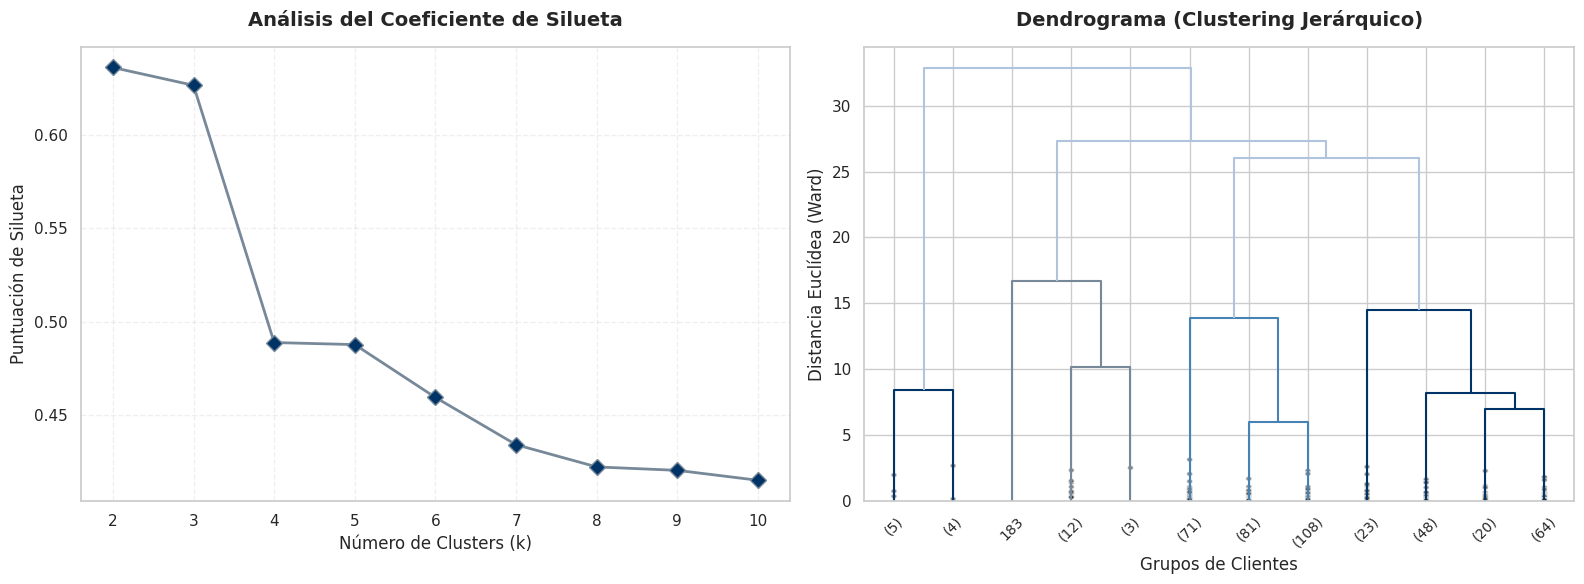

• El análisis de Silueta sugiere que la mayor cohesión se logra con k = 2


In [27]:
# ============================================================================
# 8. ESTUDIO EXTRA: VALIDACIÓN MEDIANTE SILUETA Y DENDROGRAMA
# ============================================================================
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette


set_link_color_palette(['#003366', '#778899', '#4682B4'])

K_range = range(2, 11)
silhouette_scores = []

for k in K_range:
    kmeans_eval = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans_eval.fit_predict(X_pca2)
    score = silhouette_score(X_pca2, labels)
    silhouette_scores.append(score)


Z = linkage(X_pca2, method='ward')

# --- VISUALIZACIÓN ---
plt.figure(figsize=(16, 6))

# Subplot 1: Coeficiente de Silueta
plt.subplot(1, 2, 1)
plt.plot(K_range, silhouette_scores, 'D-', color='#778899',
         markerfacecolor='#003366', markersize=8, linewidth=2)
plt.title('Análisis del Coeficiente de Silueta', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Puntuación de Silueta')
plt.xticks(K_range)
plt.grid(alpha=0.3, linestyle='--')

# Subplot 2: Dendrograma
plt.subplot(1, 2, 2)
dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=45,
    leaf_font_size=10,
    show_contracted=True,
    above_threshold_color='#B0C4DE'
)

plt.title('Dendrograma (Clustering Jerárquico)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Grupos de Clientes')
plt.ylabel('Distancia Euclídea (Ward)')

plt.tight_layout()
plt.show()

# Resumen técnico
best_k_sil = K_range[np.argmax(silhouette_scores)]
print(f"• El análisis de Silueta sugiere que la mayor cohesión se logra con k = {best_k_sil}")

### **Análisis de Silueta y Dendrograma**

Para disipar la duda técnica entre $k=3$ y $k=4$ surgida en el Método del Codo, se han aplicado dos técnicas de validación cruzada que confirman la robustez de nuestra segmentación inicial:

* **Puntuación de Silueta (Cohesión y Separación):** La gráfica muestra que la mayor calidad de agrupamiento se alcanza en **$k=2$** y **$k=3$**, con puntuaciones de silueta superiores a **0.62**. Al pasar a $k=4$, la puntuación cae drásticamente por debajo de **0.50**, lo que indica que añadir un cuarto grupo generaría segmentos solapados y artificiales, perdiendo la claridad que ofrece el modelo de tres grupos.
* **Análisis Jerárquico (Dendrograma):** Al observar el dendrograma basado en el método de Ward, se identifican claramente tres grandes ramas principales antes de que las distancias de unión se vuelvan pequeñas y ruidosas. La longitud de las líneas verticales en los tres grupos superiores confirma que existe una separación natural muy fuerte en estos niveles, validando la estructura de **Retail, Horeca y Grandes Cuentas**.

Ambos métodos ratifican que **$k=3$ es la elección óptima**. Mientras que el Método del Codo sugería que $k=4$ reducía más la inercia, la Silueta demuestra que esa reducción extra no compensa la pérdida de definición y cohesión de los grupos. Por lo tanto, mantenemos nuestra segmentación original por su solvencia estadística y utilidad para el negocio.
